---
title: Analise
author: Leonardo Camilo
execute:
    echo: false
    warnings: false
    message: false
jupyter: python3
---

Análise Detalhada: Analistas vs Pareceristas - Lei do Bem 2021
==============================================================

Este notebook analisa a relação entre as decisões dos analistas (fase DO)
e dos pareceristas (fase Parecer) nos projetos da Lei do Bem.

Perguntas a serem respondidas:
1. Taxa de aprovação por analista
2. Taxa de concordância DO → Parecer
3. Reversões de decisão (Não Recomendado → Recomendado)
4. Dispersão de áreas por analista
5. Fichas individuais dos top 15 analistas
6. Modelo preditivo de aprovação no Parecer

# Análise de Decisões no Processo da Lei do Bem (2021): Analistas e Pareceristas

## 1. Introdução

Esta análise aprofundada explora as decisões tomadas por analistas e pareceristas no âmbito do programa Lei do Bem do MCTI, um dos principais instrumentos de fomento à inovação no Brasil. O estudo se baseia em um volume expressivo de dados, compreendendo 13.198 projetos analisados durante o ano de 2021. O objetivo geral é identificar padrões, inconsistências e insights nas avaliações, visando otimizar a eficiência, a isonomia e a previsibilidade do processo de concessão de incentivos fiscais para Pesquisa e Desenvolvimento (P&D).

## 2. Metodologia

A análise foi conduzida a partir de um banco de dados consolidado contendo informações detalhadas sobre cada um dos 13.198 projetos do ano-base de 2021. As fontes de dados incluem os pareceres técnicos emitidos tanto pelo Ministério (fase DO) quanto pelos pesquisadores ad hoc (fase Parecer), além de metadados dos projetos, como áreas de conhecimento e informações textuais descritivas.
As técnicas aplicadas envolveram desde a estatística descritiva, para quantificar taxas de aprovação e concordância, até a análise de dispersão para entender a distribuição de projetos entre os representantes do Ministério. Um dos pilares da metodologia foi o processamento de linguagem natural (PLN), utilizado para extrair insights dos campos textuais. Para isso, a biblioteca NLTK (Natural Language Toolkit) foi empregada para processar os textos em português, aplicando a remoção de stopwords (palavras comuns como "de", "para", "com") para focar nos termos mais relevantes de cada projeto.
O conjunto de stopwords foi composto por 207 palavras do NLTK e um conjunto customizado de 71 termos específicos do domínio da Lei do Bem, totalizando 278 palavras removidas para garantir uma análise mais limpa e focada. Além disso, foi desenvolvido um modelo de Machine Learning para explorar a capacidade preditiva dos dados textuais em relação à aprovação final dos projetos.

### Análise de Analistas vs Pareceristas - Lei do Bem 2021

**Data de Análise:** 22/07/2025

**Ano Base dos Dados:** 2018 à 2023

**Total de Projetos:** 13.198

In [2]:
#| echo: false
# %% Imports e Configuração
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import re
from collections import Counter
import nltk

# Baixar recursos necessários do NLTK

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Baixando punkt...")
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("Baixando stopwords...")
    nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Configurar fonte para melhor visualização em PDF
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 300

# %% Configuração de stopwords em português
# Carregar stopwords padrão do NLTK em português
stop_words_nltk = set(stopwords.words('portuguese'))

# Adicionar stopwords específicas do domínio Lei do Bem
stop_words_dominio = {
    # Verbos comuns
    'realizar', 'desenvolver', 'criar', 'implementar', 'utilizar', 'aplicar', 'melhorar',
    'analisar', 'estudar', 'avaliar', 'testar', 'produzir', 'fabricar', 'construir', 'usar', 'uso'
    
    # Preposições e conectivos adicionais
    'através', 'mediante', 'partir', 'base', 'forma', 'modo', 'tipo', 'fase', 'etapa',
    'objetivo', 'objetivos', 'finalidade', 'propósito', 'meta', 'metas',
    
    # Termos muito genéricos
    'novo', 'nova', 'novos', 'novas', 'área', 'áreas', 'setor', 'setores',
    'atividade', 'atividades', 'trabalho', 'trabalhos', 'serviço', 'serviços'
}

# Combinar todas as stopwords
todas_stopwords = stop_words_nltk.union(stop_words_dominio)

In [3]:
# %% Funções de processamento de texto simplificadas
def limpar_texto(texto):
    """Limpa e normaliza o texto"""
    if pd.isna(texto) or not texto:
        return ""
    
    # Converter para string e minúsculas
    texto = str(texto).lower()
    
    # Remover caracteres especiais, mantendo espaços e letras
    texto = re.sub(r'[^a-záàâãéèêíïóôõöúçñ\s]', ' ', texto)
    
    # Remover espaços múltiplos
    texto = re.sub(r'\s+', ' ', texto)
    
    return texto.strip()

def analisar_texto_stopwords(texto, stopwords_set):
    """
    Analisa um texto e retorna estatísticas sobre stopwords
    """
    if pd.isna(texto) or not texto:
        return {
            'texto_original': '',
            'texto_sem_stopwords': '',
            'palavras_total': 0,
            'palavras_sem_stopwords': 0,
            'stopwords_encontradas': [],
            'palavras_relevantes': [],
            'reducao_percentual': 0
        }
    
    # Converter para string primeiro para garantir
    texto_str = str(texto)
    
    # Limpar texto
    texto_limpo = limpar_texto(texto_str)
    
    # Tokenizar
    palavras = texto_limpo.split()
    palavras_total = len(palavras)
    
    # Filtrar stopwords
    palavras_sem_stop = [p for p in palavras if p not in stopwords_set and len(p) > 2]
    stopwords_encontradas = [p for p in palavras if p in stopwords_set]
    
    # Calcular redução
    reducao = ((palavras_total - len(palavras_sem_stop)) / palavras_total * 100) if palavras_total > 0 else 0
    
    # Preparar texto original para retorno (truncado se muito longo)
    texto_original_truncado = texto_str[:200] + '...' if len(texto_str) > 200 else texto_str
    
    return {
        'texto_original': texto_original_truncado,
        'texto_sem_stopwords': ' '.join(palavras_sem_stop),
        'palavras_total': palavras_total,
        'palavras_sem_stopwords': len(palavras_sem_stop),
        'stopwords_encontradas': stopwords_encontradas,
        'palavras_relevantes': palavras_sem_stop[:20],  # Top 20 palavras
        'reducao_percentual': reducao
    }

def processar_campos_texto(df, campos, stopwords_set):
    """
    Processa múltiplos campos de texto e retorna análise de stopwords
    """
    resultados = {}
    
    for campo in campos:
        if campo not in df.columns:
            print(f"⚠️ Campo {campo} não encontrado")
            continue
            
        print(f"📝 Processando {campo}...")
        
        # Analisar cada texto
        analises = df[campo].apply(lambda x: analisar_texto_stopwords(x, stopwords_set))
        
        # Extrair métricas
        resultados[campo] = {
            'df_analise': pd.DataFrame(list(analises)),
            'reducao_media': np.mean([a['reducao_percentual'] for a in analises]),
            'palavras_media_original': np.mean([a['palavras_total'] for a in analises]),
            'palavras_media_filtrado': np.mean([a['palavras_sem_stopwords'] for a in analises])
        }
        
        # Contar palavras mais frequentes após filtro
        todas_palavras_relevantes = []
        for analise in analises:
            todas_palavras_relevantes.extend(analise['palavras_relevantes'])
        
        contador_palavras = Counter(todas_palavras_relevantes)
        resultados[campo]['top_palavras'] = contador_palavras.most_common(20)
        
        # Contar stopwords mais comuns
        todas_stopwords = []
        for analise in analises:
            todas_stopwords.extend(analise['stopwords_encontradas'])
        
        contador_stopwords = Counter(todas_stopwords)
        resultados[campo]['top_stopwords'] = contador_stopwords.most_common(20)
    
    return resultados

## 1. Carregamento e Preparação dos Dados

CAPÍTULO 1: CARREGAMENTO E PREPARAÇÃO DOS DADOS

1.1 Carregamento do Dataset Principal

Dataset carregado com sucesso!
├── Total de projetos: 75,816
└── Total de variáveis: 229

1.2 Seleção de Variáveis Relevantes

Variáveis selecionadas por categoria:
├── Identificação: 5
├── Projeto: 7
├── Ministério: 2
├── Pesquisador: 1
└── Valores: 2

Total de variáveis selecionadas: 17

1.3 Análise Textual e Processamento de Linguagem Natural

Campos textuais identificados para análise: 4

Configurando conjunto de stopwords...
├── Stopwords NLTK português: 207
├── Stopwords domínio específico: 55
└── Total de stopwords: 255

Processando campos textuais...

Processando: Descrição do Projeto
├── Palavras médias (original): 268.0
├── Palavras médias (limpo): 147.1
└── Redução média: 44.5%

Processando: Elemento Tecnológico
├── Palavras médias (original): 306.5
├── Palavras médias (limpo): 168.7
└── Redução média: 44.7%

Processando: Desafio Tecnológico
├── Palavras médias (original): 293.4
├── Palav

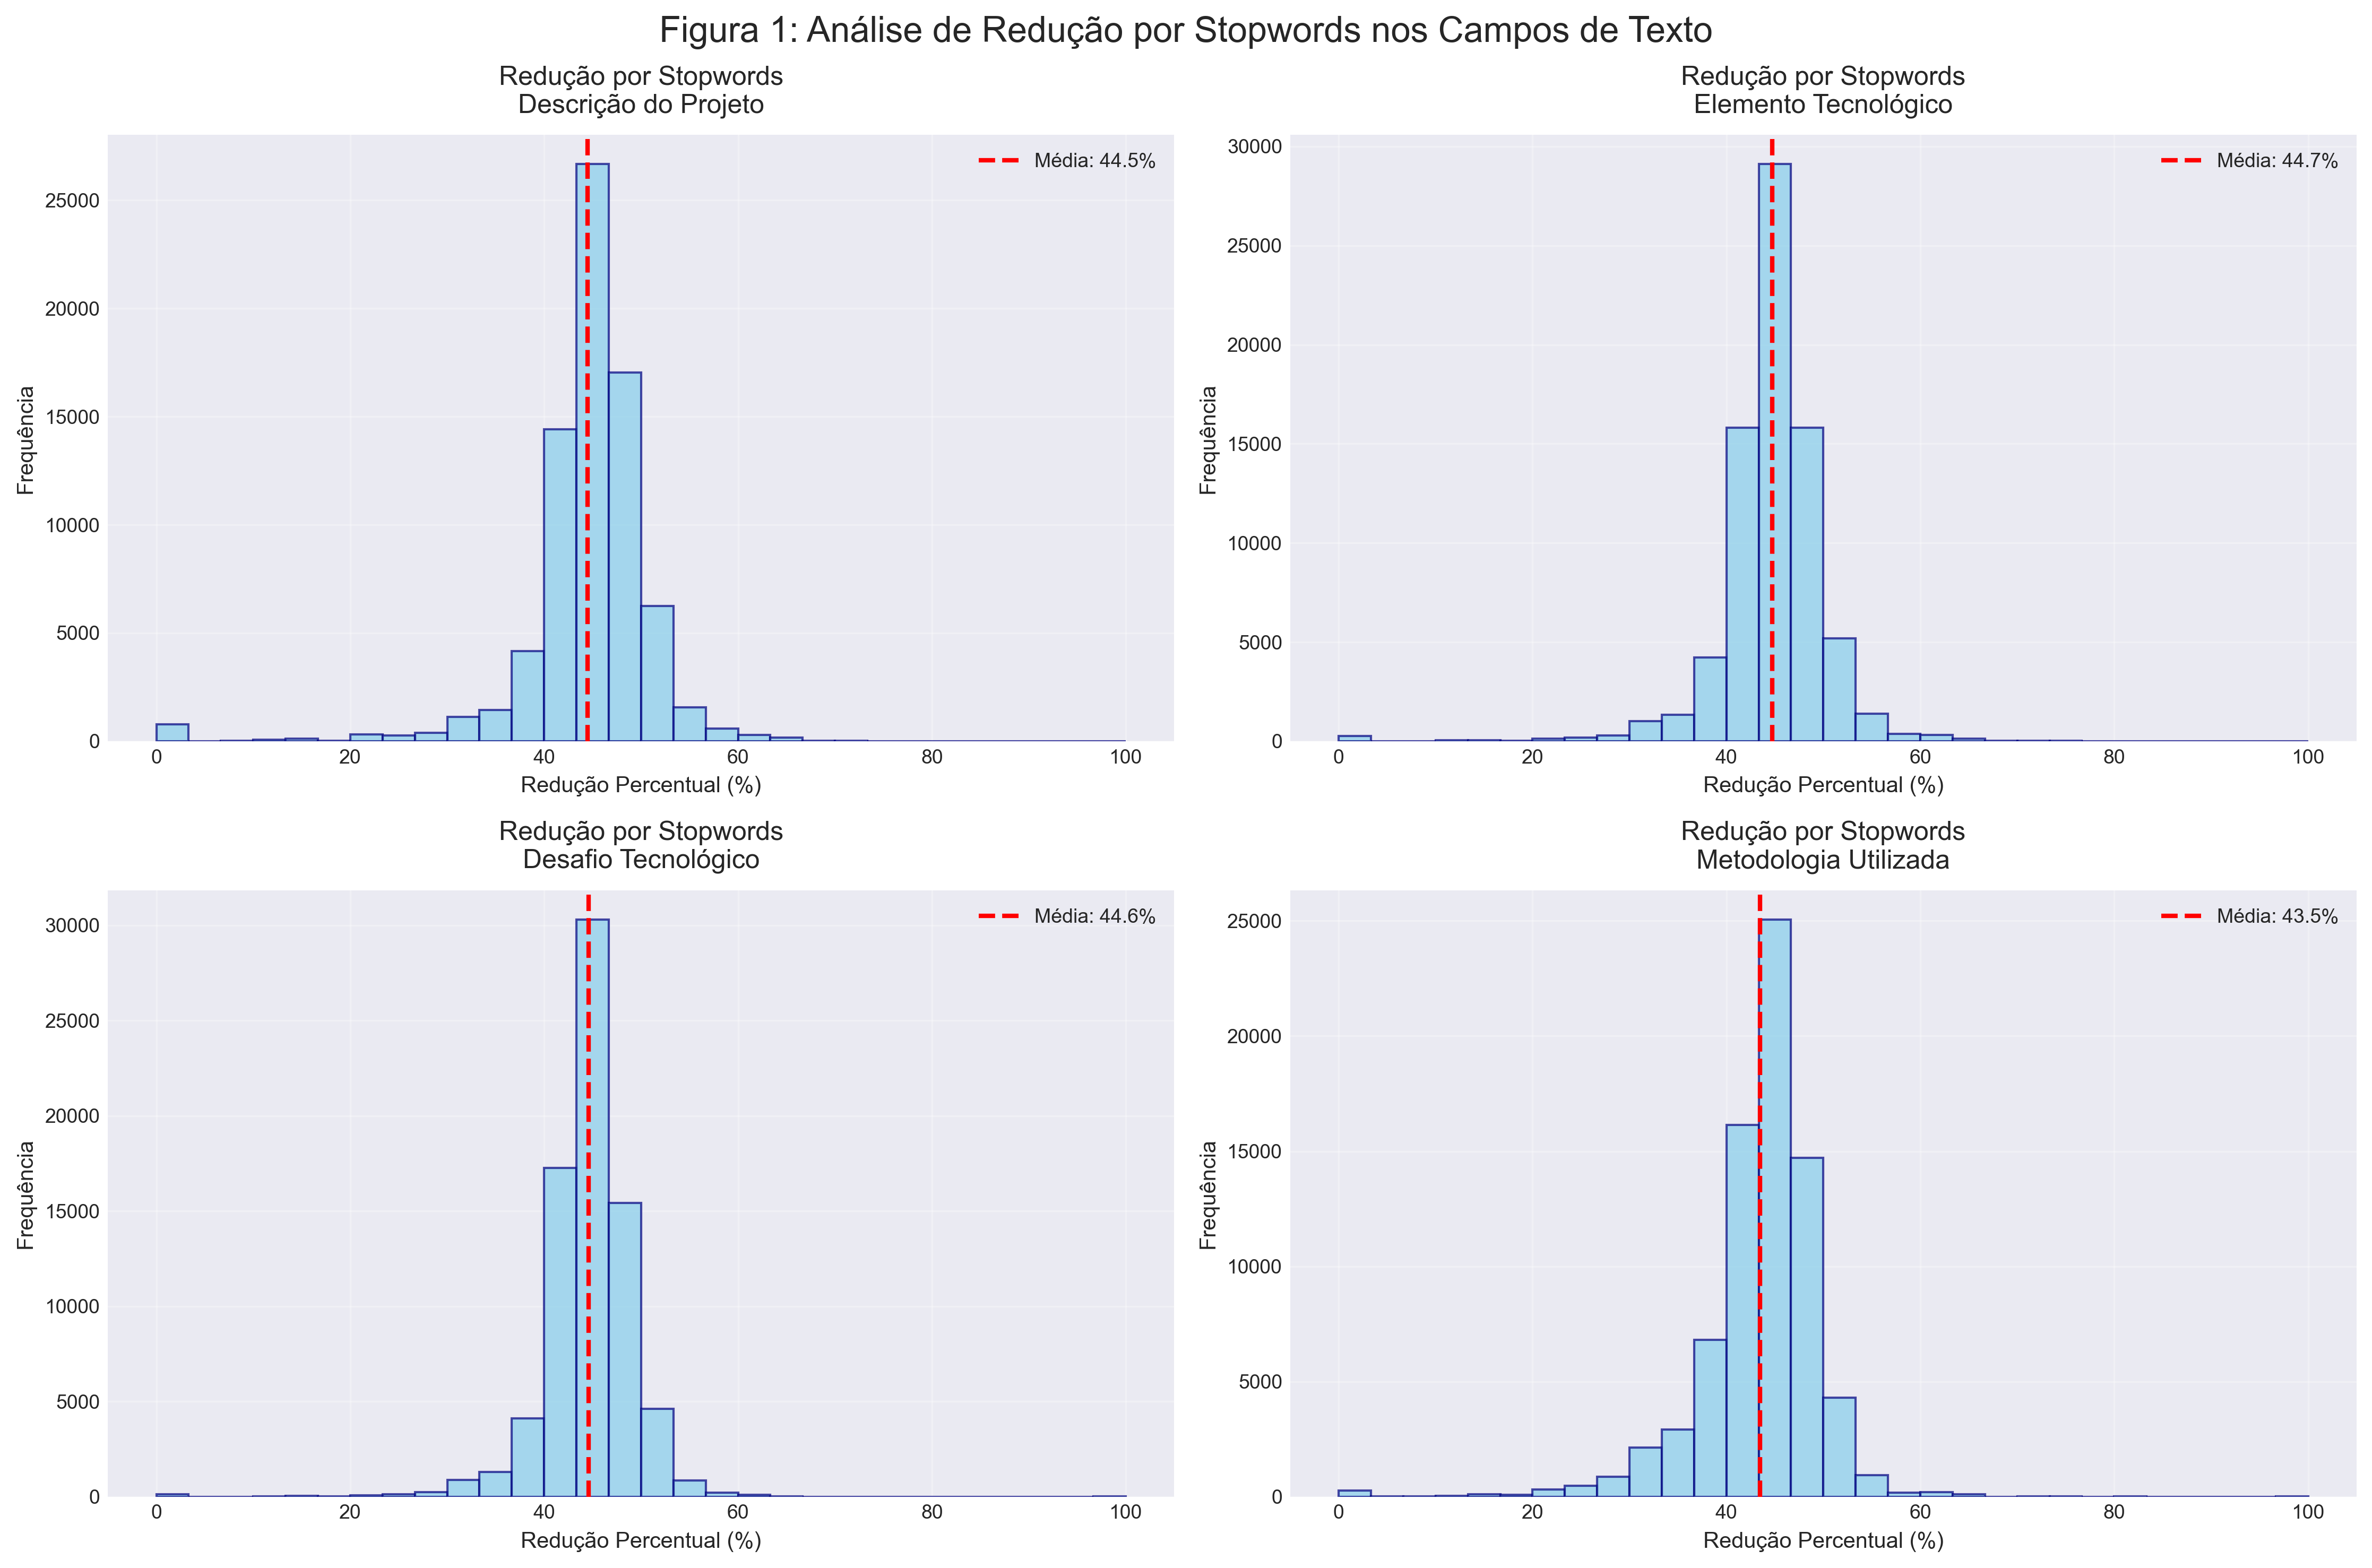

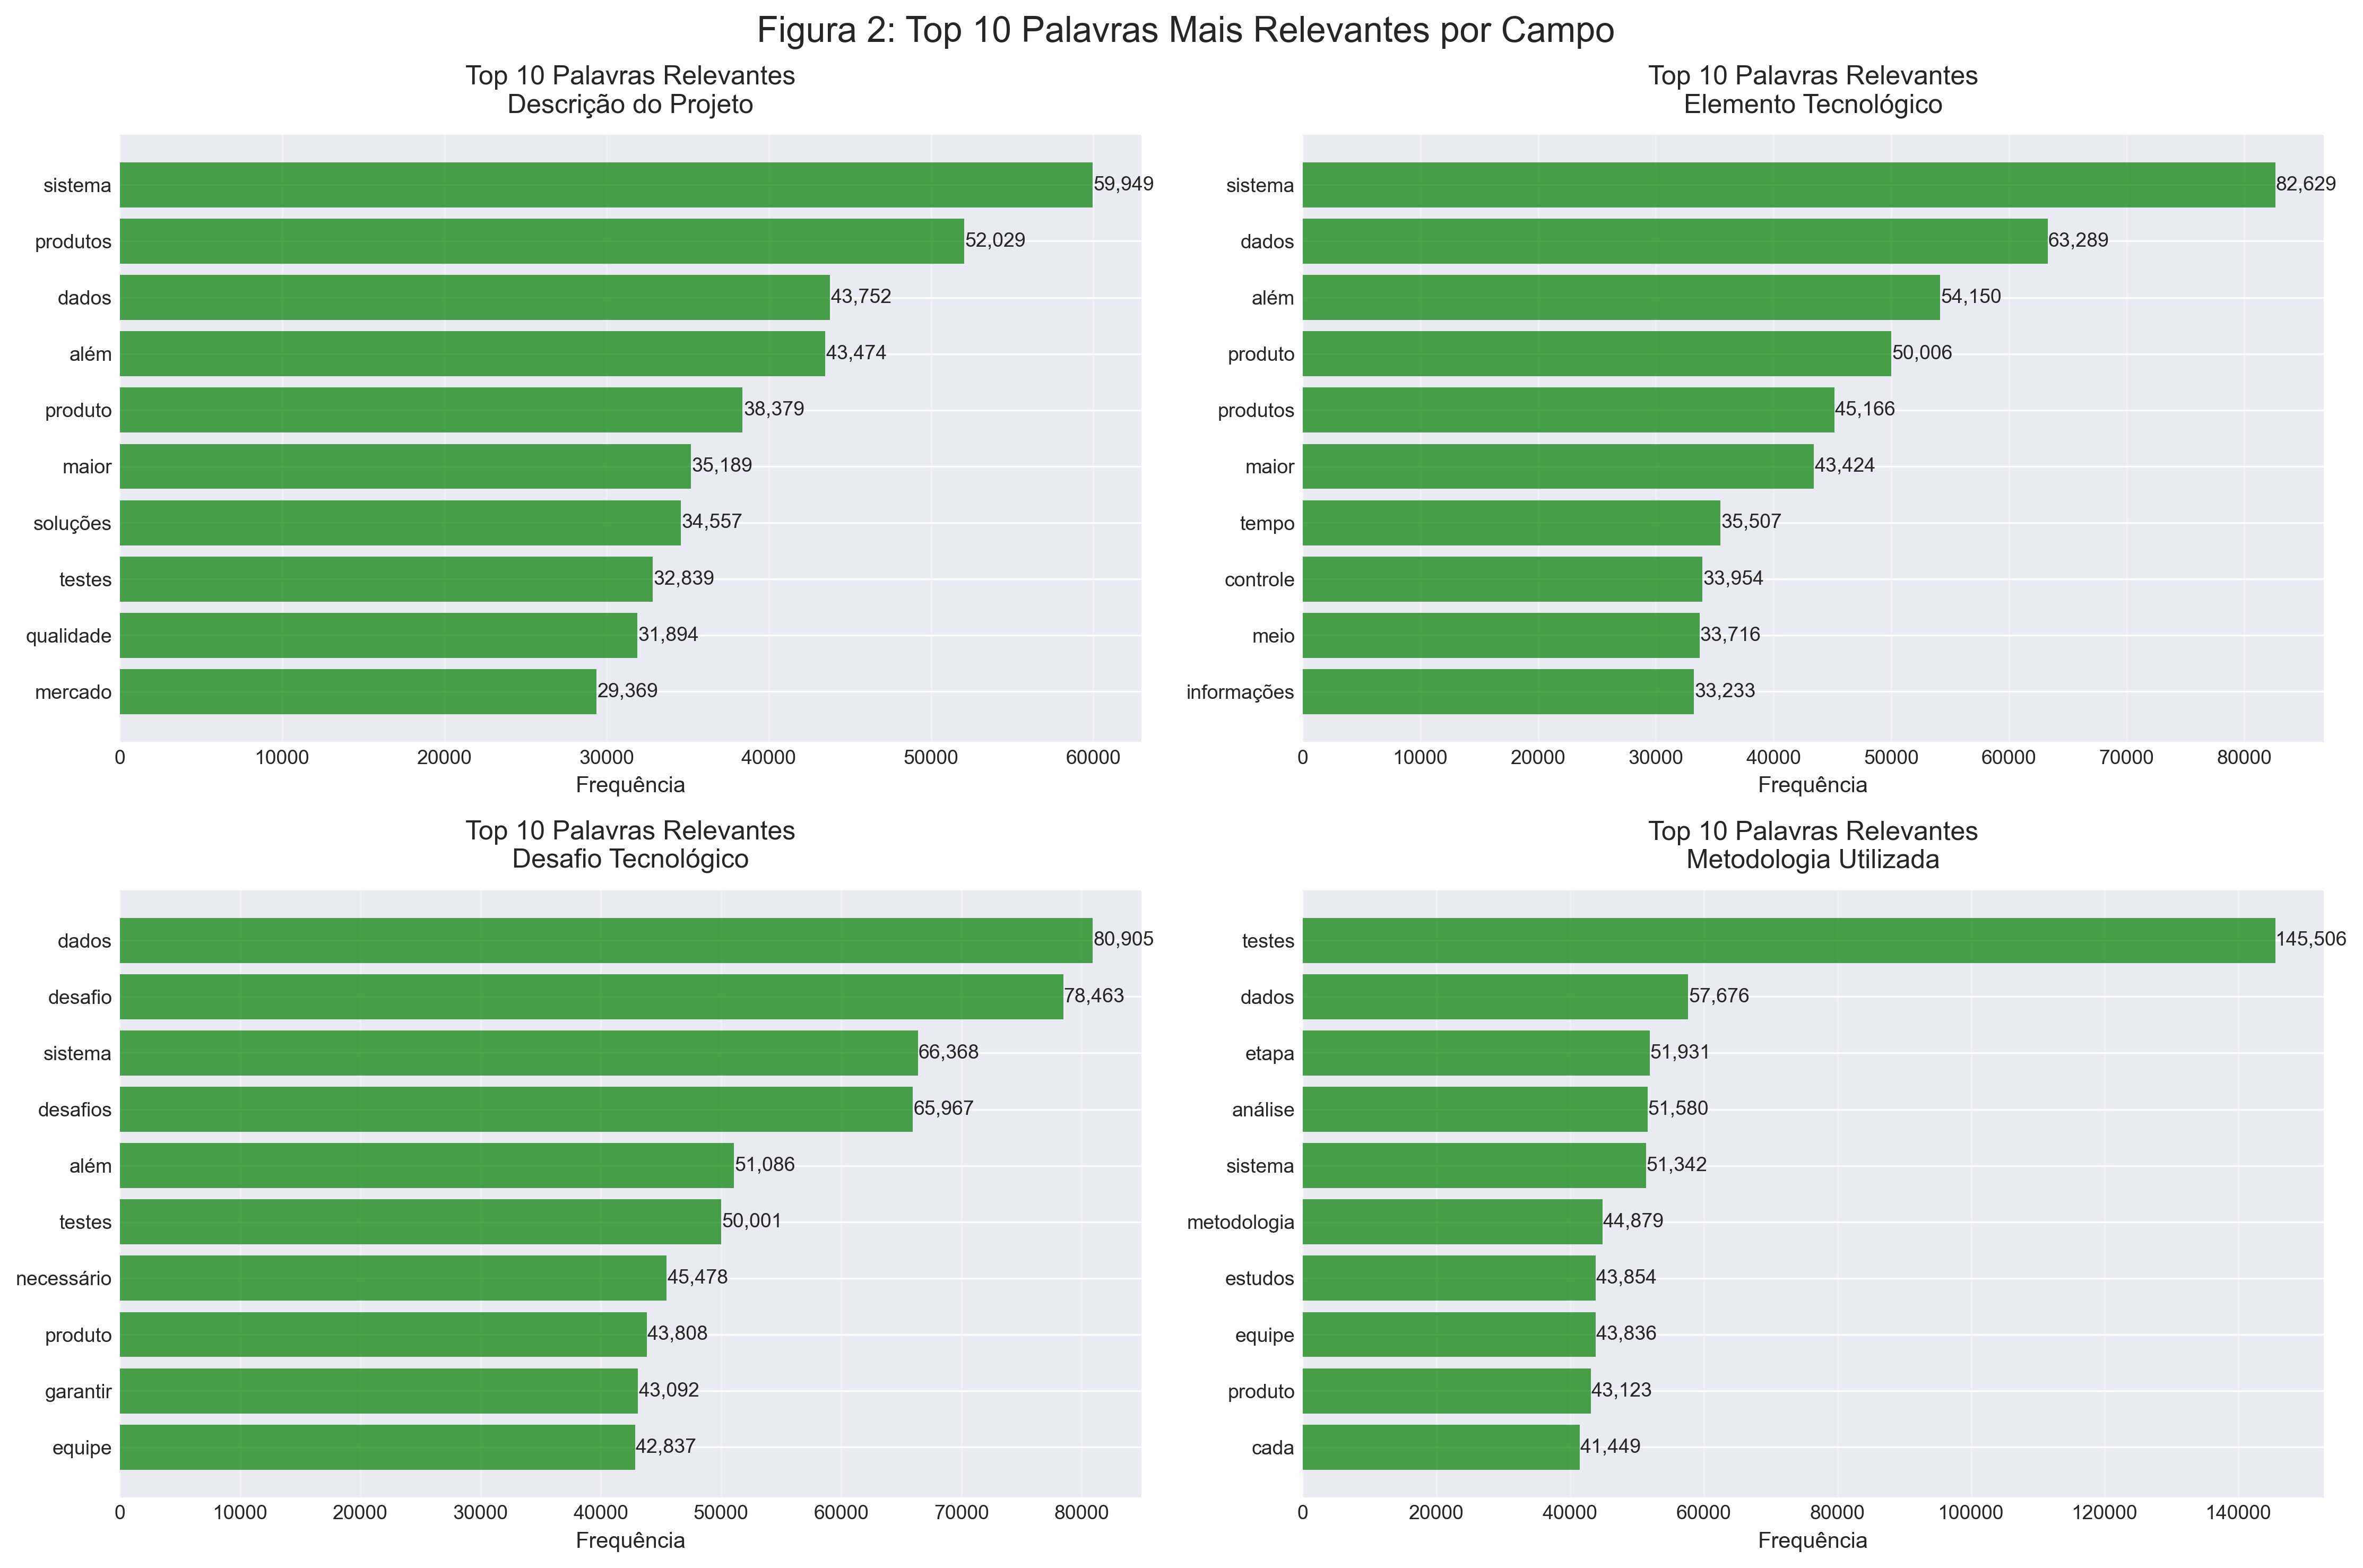


1.5 Preparação Final do Dataset

Criando campo de texto combinado...

Dataset preparado com sucesso!
├── Total de projetos: 75,816
├── Variáveis originais: 17
├── Variáveis criadas: 9
└── Total de variáveis: 26

Exemplo de Processamento (Projeto #1):
------------------------------------------------------------
Original: Em 2018, a Abbott realizou atividades de pesquisa e desenvolvimento de medicamentos e polivitamínicos. As limitações técnicas deste projeto envolvem i...
Limpo: 2018, abbott realizou medicamentos polivitamínicos. limitações técnicas deste envolvem incertezas relação estabilidade fórmulas desenvolvidas, eficáci...
Redução: 42.0%

CAPÍTULO 1 CONCLUÍDO - Dataset pronto para análise


In [4]:
"""
Capítulo 1: Carregamento e Preparação dos Dados
Análise da Lei do Bem - Ano Base 2021

Este script realiza o carregamento inicial dos dados e prepara o dataset
para análises posteriores, incluindo processamento de linguagem natural
dos campos textuais.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Configuração visual-0
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# =============================================================================
# SEÇÃO 1.1: CARREGAMENTO DO DATASET
# =============================================================================

print("=" * 80)
print("CAPÍTULO 1: CARREGAMENTO E PREPARAÇÃO DOS DADOS")
print("=" * 80)
print("\n1.1 Carregamento do Dataset Principal\n")

# Carregar arquivo CSV principal
arquivo_dados = 'csv_longo/projetos_lei_do_bem_DETALHADO_LINHA_UNICA.csv'
df = pd.read_csv(arquivo_dados, sep=';', encoding='utf-8')

# Estatísticas iniciais
total_projetos = len(df)
total_colunas = len(df.columns)

print(f"Dataset carregado com sucesso!")
print(f"├── Total de projetos: {total_projetos:,}")
print(f"└── Total de variáveis: {total_colunas}")

# =============================================================================
# SEÇÃO 1.2: SELEÇÃO DE VARIÁVEIS RELEVANTES
# =============================================================================

print("\n1.2 Seleção de Variáveis Relevantes\n")

# Definir grupos de colunas por categoria
colunas_identificacao = [
    'lst_idprenchimentosituacaoanalise', 'lst_norazaosocial', 'lst_nrcnpj',
    'lst_noatividadeeconomica', 'daproj_nritem'
]

colunas_projeto = [
    'daproj_noprojeto', 'daproj_dsprojeto', 'daproj_dsareaprojeto',
    'daproj_dspalavrachave', 'daproj_dselementotecnologico',
    'daproj_dsdesafiotecnologico', 'daproj_dsmetodologiautilizada'
]

colunas_ministerio = [
    'do_saat_idunicopessoaanalise', 'do_taaproj_notipoavaliacaoanalise'
]

colunas_pesquisador = [
    'p_taaproj_notipoavaliacaoanalise'
]

colunas_valores = [
    'do_aat_vltotaldeclarado', 'do_aat_vltotalparecer'
]

# Combinar todas as colunas
colunas_analise = (colunas_identificacao + colunas_projeto + 
                   colunas_ministerio + colunas_pesquisador + colunas_valores)

# Filtrar apenas colunas existentes no dataset
colunas_existentes = [col for col in colunas_analise if col in df.columns]
df_analise = df[colunas_existentes].copy()

print(f"Variáveis selecionadas por categoria:")
print(f"├── Identificação: {len([c for c in colunas_identificacao if c in colunas_existentes])}")
print(f"├── Projeto: {len([c for c in colunas_projeto if c in colunas_existentes])}")
print(f"├── Ministério: {len([c for c in colunas_ministerio if c in colunas_existentes])}")
print(f"├── Pesquisador: {len([c for c in colunas_pesquisador if c in colunas_existentes])}")
print(f"└── Valores: {len([c for c in colunas_valores if c in colunas_existentes])}")
print(f"\nTotal de variáveis selecionadas: {len(colunas_existentes)}")

# =============================================================================
# SEÇÃO 1.3: ANÁLISE TEXTUAL E PROCESSAMENTO DE LINGUAGEM NATURAL
# =============================================================================

print("\n1.3 Análise Textual e Processamento de Linguagem Natural\n")

# 1.3.1 Identificação de campos textuais
campos_texto = {
    'daproj_dsprojeto': 'Descrição do Projeto',
    'daproj_dselementotecnologico': 'Elemento Tecnológico',
    'daproj_dsdesafiotecnologico': 'Desafio Tecnológico',
    'daproj_dsmetodologiautilizada': 'Metodologia Utilizada'
}

campos_texto_existentes = {k: v for k, v in campos_texto.items() if k in df_analise.columns}
print(f"Campos textuais identificados para análise: {len(campos_texto_existentes)}")

# 1.3.2 Configuração de stopwords
print("\nConfigurando conjunto de stopwords...")

# Baixar stopwords do NLTK se necessário
try:
    stopwords_pt = set(stopwords.words('portuguese'))
except:
    nltk.download('stopwords')
    stopwords_pt = set(stopwords.words('portuguese'))

# Stopwords específicas do domínio Lei do Bem
stopwords_dominio = {
    'ano', 'base', 'projeto', 'projetos', 'empresa', 'empresas',
    'desenvolvimento', 'pesquisa', 'inovação', 'tecnológica',
    'realizar', 'realizado', 'realizada', 'realizados', 'realizadas',
    'objetivo', 'objetivos', 'processo', 'processos', 'atividade',
    'atividades', 'trabalho', 'trabalhos', 'forma', 'formas',
    'através', 'partir', 'sendo', 'foram', 'seja', 'sejam',
    'pode', 'podem', 'deve', 'devem', 'está', 'estão',
    'fazer', 'feito', 'feita', 'ter', 'tem', 'tinha',
    'uso', 'usar', 'usado', 'usada', 'novo', 'nova',
    'novos', 'novas', 'ainda', 'apenas', 'assim', 'então'
}

todas_stopwords = stopwords_pt.union(stopwords_dominio)
print(f"├── Stopwords NLTK português: {len(stopwords_pt)}")
print(f"├── Stopwords domínio específico: {len(stopwords_dominio)}")
print(f"└── Total de stopwords: {len(todas_stopwords)}")

# 1.3.3 Função para processar texto
def processar_texto(texto, stopwords_set):
    """
    Processa um texto removendo stopwords e normalizando.
    
    Args:
        texto: String com o texto a ser processado
        stopwords_set: Conjunto de stopwords a remover
        
    Returns:
        dict: Dicionário com texto processado e estatísticas
    """
    if pd.isna(texto):
        return {
            'texto_original': '',
            'texto_limpo': '',
            'palavras_originais': 0,
            'palavras_limpas': 0,
            'reducao_percentual': 0
        }
    
    # Converter para string e lowercase
    texto_str = str(texto).lower()
    
    # Tokenização simples
    palavras_originais = texto_str.split()
    num_palavras_originais = len(palavras_originais)
    
    # Remover stopwords
    palavras_limpas = [p for p in palavras_originais if p not in stopwords_set]
    num_palavras_limpas = len(palavras_limpas)
    
    # Calcular redução
    reducao = 0 if num_palavras_originais == 0 else (
        (num_palavras_originais - num_palavras_limpas) / num_palavras_originais * 100
    )
    
    return {
        'texto_original': texto_str,
        'texto_limpo': ' '.join(palavras_limpas),
        'palavras_originais': num_palavras_originais,
        'palavras_limpas': num_palavras_limpas,
        'reducao_percentual': reducao
    }

# 1.3.4 Processar todos os campos textuais
print("\nProcessando campos textuais...")

resultados_processamento = {}

for campo, nome in campos_texto_existentes.items():
    print(f"\nProcessando: {nome}")
    
    # Aplicar processamento
    processados = df_analise[campo].apply(lambda x: processar_texto(x, todas_stopwords))
    
    # Extrair resultados
    df_temp = pd.DataFrame(processados.tolist())
    
    # Calcular estatísticas
    palavras_originais_media = df_temp['palavras_originais'].mean()
    palavras_limpas_media = df_temp['palavras_limpas'].mean()
    reducao_media = df_temp['reducao_percentual'].mean()
    
    # Contar palavras mais frequentes após limpeza
    todas_palavras_limpas = ' '.join(df_temp['texto_limpo']).split()
    contador_palavras = Counter(todas_palavras_limpas)
    top_palavras = contador_palavras.most_common(20)
    
    # Armazenar resultados
    resultados_processamento[campo] = {
        'nome': nome,
        'df_processado': df_temp,
        'palavras_originais_media': palavras_originais_media,
        'palavras_limpas_media': palavras_limpas_media,
        'reducao_media': reducao_media,
        'top_palavras': top_palavras
    }
    
    # Adicionar colunas processadas ao dataframe principal
    df_analise[f'{campo}_limpo'] = df_temp['texto_limpo']
    df_analise[f'{campo}_num_palavras_limpo'] = df_temp['palavras_limpas']
    
    print(f"├── Palavras médias (original): {palavras_originais_media:.1f}")
    print(f"├── Palavras médias (limpo): {palavras_limpas_media:.1f}")
    print(f"└── Redução média: {reducao_media:.1f}%")

# =============================================================================
# SEÇÃO 1.4: VISUALIZAÇÕES
# =============================================================================

print("\n1.4 Gerando Visualizações\n")

# Figura 1: Análise de Redução por Stopwords
fig1, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (campo, resultado) in enumerate(resultados_processamento.items()):
    ax = axes[i]
    
    # Histograma de redução percentual
    df_vis = resultado['df_processado']
    df_vis['reducao_percentual'].hist(bins=30, ax=ax, color='skyblue', edgecolor='navy', alpha=0.7)
    
    # Adicionar linha de média
    ax.axvline(resultado['reducao_media'], color='red', linestyle='--', linewidth=2,
               label=f'Média: {resultado["reducao_media"]:.1f}%')
    
    # Configurar eixos e título
    ax.set_title(f'Redução por Stopwords\n{resultado["nome"]}', fontsize=12, pad=10)
    ax.set_xlabel('Redução Percentual (%)')
    ax.set_ylabel('Frequência')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Figura 1: Análise de Redução por Stopwords nos Campos de Texto', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Figura 2: Top Palavras Relevantes
fig2, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (campo, resultado) in enumerate(resultados_processamento.items()):
    ax = axes[i]
    
    # Top 10 palavras
    palavras = [p[0] for p in resultado['top_palavras'][:10]]
    frequencias = [p[1] for p in resultado['top_palavras'][:10]]
    
    # Criar gráfico de barras horizontal
    y_pos = np.arange(len(palavras))
    bars = ax.barh(y_pos, frequencias, color='green', alpha=0.7)
    
    # Configurar eixos
    ax.set_yticks(y_pos)
    ax.set_yticklabels(palavras)
    ax.invert_yaxis()
    ax.set_xlabel('Frequência')
    ax.set_title(f'Top 10 Palavras Relevantes\n{resultado["nome"]}', fontsize=12, pad=10)
    ax.grid(axis='x', alpha=0.3)
    
    # Adicionar valores nas barras
    for j, (bar, freq) in enumerate(zip(bars, frequencias)):
        ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, 
                f'{freq:,}', va='center', fontsize=9)

plt.suptitle('Figura 2: Top 10 Palavras Mais Relevantes por Campo', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# =============================================================================
# SEÇÃO 1.5: PREPARAÇÃO FINAL DO DATASET
# =============================================================================

print("\n1.5 Preparação Final do Dataset\n")

# Criar campo de texto combinado
print("Criando campo de texto combinado...")
textos_combinados = []

for idx in range(len(df_analise)):
    partes = []
    for campo in campos_texto_existentes.keys():
        campo_limpo = f'{campo}_limpo'
        if campo_limpo in df_analise.columns:
            texto = str(df_analise[campo_limpo].iloc[idx])
            if texto and texto != 'nan':
                partes.append(texto)
    
    texto_combinado = ' '.join(partes)
    textos_combinados.append(texto_combinado)

df_analise['texto_combinado_limpo'] = textos_combinados

# Estatísticas finais
print(f"\nDataset preparado com sucesso!")
print(f"├── Total de projetos: {len(df_analise):,}")
print(f"├── Variáveis originais: {len(colunas_existentes)}")
print(f"├── Variáveis criadas: {len([c for c in df_analise.columns if 'limpo' in c])}")
print(f"└── Total de variáveis: {len(df_analise.columns)}")

# Exemplo de processamento
print("\nExemplo de Processamento (Projeto #1):")
print("-" * 60)
campo_exemplo = 'daproj_dsprojeto'
if campo_exemplo in df_analise.columns:
    texto_original = str(df_analise[campo_exemplo].iloc[0])[:150]
    texto_limpo = str(df_analise[f'{campo_exemplo}_limpo'].iloc[0])[:150]
    reducao = resultados_processamento[campo_exemplo]['df_processado']['reducao_percentual'].iloc[0]
    
    print(f"Original: {texto_original}...")
    print(f"Limpo: {texto_limpo}...")
    print(f"Redução: {reducao:.1f}%")

print("\n" + "=" * 80)
print("CAPÍTULO 1 CONCLUÍDO - Dataset pronto para análise")
print("=" * 80)

## 2. Análise Exploratória Inicial

In [5]:
# %% Estatísticas básicas
# Verificar valores únicos nas colunas de decisão
print("Valores únicos em 'do_taaproj_notipoavaliacaoanalise' (Pesquisador ad hoc):")
print(df_analise['do_taaproj_notipoavaliacaoanalise'].value_counts())

print("\n\nValores únicos em 'p_taaproj_notipoavaliacaoanalise' (Ministério):")
print(df_analise['p_taaproj_notipoavaliacaoanalise'].value_counts())

# Filtrar apenas projetos que passaram por ambas as fases
df_completo = df_analise[
    df_analise['do_taaproj_notipoavaliacaoanalise'].notna() & 
    df_analise['p_taaproj_notipoavaliacaoanalise'].notna()
].copy()

print(f"\n\nProjetos com análise completa (Pesquisador + Ministério): {len(df_completo):,}")

Valores únicos em 'do_taaproj_notipoavaliacaoanalise' (Pesquisador ad hoc):
do_taaproj_notipoavaliacaoanalise
Recomendado        48112
Não Recomendado    27682
Abonado               19
Name: count, dtype: int64


Valores únicos em 'p_taaproj_notipoavaliacaoanalise' (Ministério):
p_taaproj_notipoavaliacaoanalise
Recomendado        42575
Não Recomendado    25903
Name: count, dtype: int64


Projetos com análise completa (Pesquisador + Ministério): 68,475


## Análise de Quadrante de Decisão

Análise dos quadrantes de decisão entre Pesquisadores e Ministério.

ANÁLISE DE QUADRANTES DE DECISÃO

📊 Matriz de Decisões:
Ministério            Não Recomendado  Recomendado  Total
Pesquisador (ad hoc)                                     
Não Recomendado                 20794         5898  26692
Recomendado                      5104        36660  41764
Total                           25898        42558  68456

⚠️ 19 projetos foram excluídos da análise por terem decisão 'Outro'


📊 ANÁLISE POR QUADRANTES:
------------------------------------------------------------
Quadrante 1 - Recomendado por AMBOS (Pesquisador E Ministério):
  → 36,660 projetos (53.6%)

Quadrante 2 - Recomendado pelo Pesquisador, NÃO pelo Ministério:
  → 5,104 projetos (7.5%)

Quadrante 3 - NÃO Recomendado pelo Pesquisador, SIM pelo Ministério:
  → 5,898 projetos (8.6%)

Quadrante 4 - NÃO Recomendado por AMBOS:
  → 20,794 projetos (30.4%)
------------------------------------------------------------
Total: 68,456 projetos


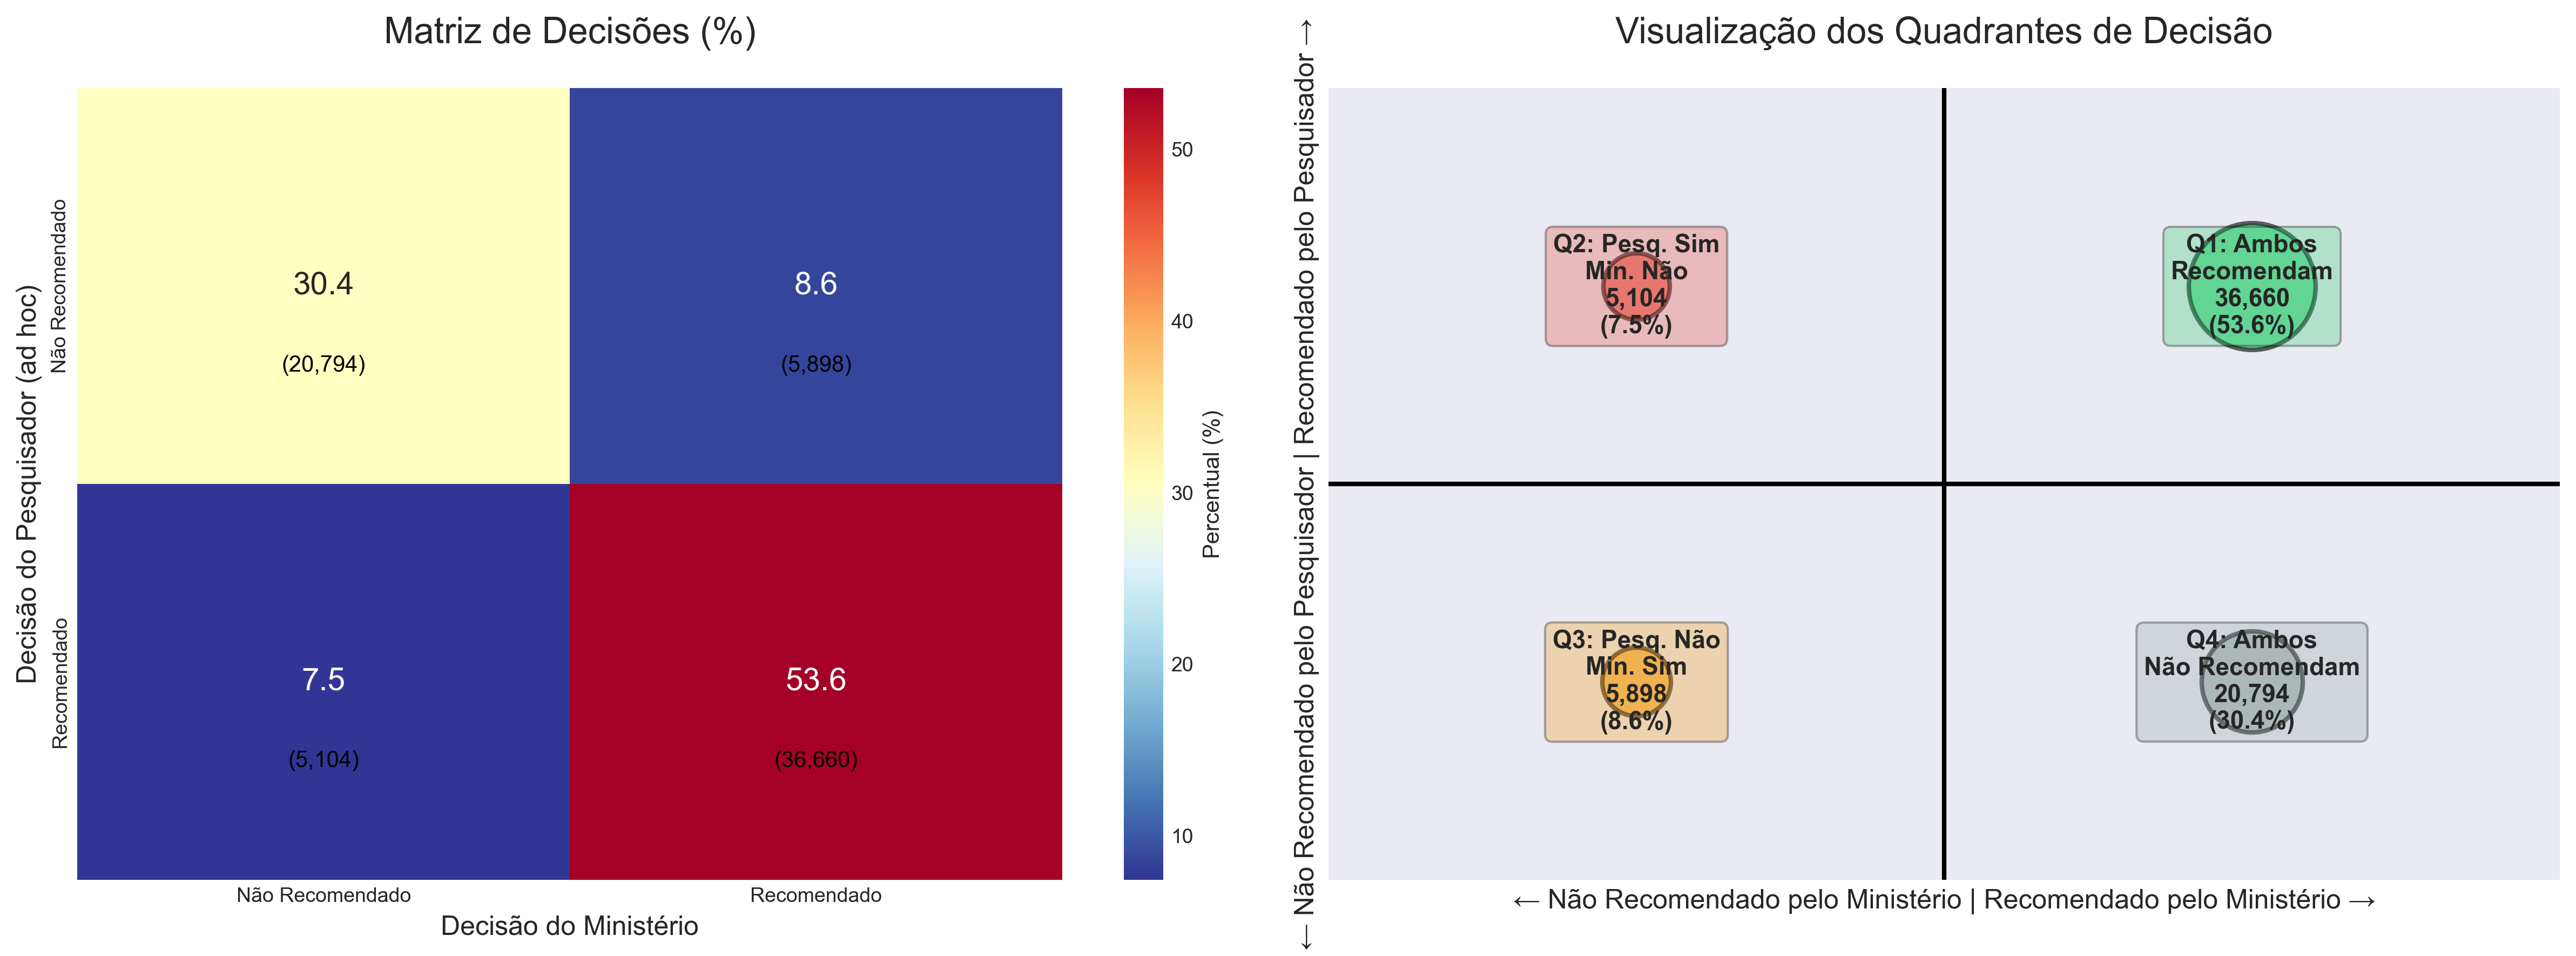


📊 MÉTRICAS DE CONCORDÂNCIA:
Taxa de Concordância Total: 83.9%
Taxa de Discordância Total: 16.1%

Dentro das discordâncias:
  - Pesquisador mais rigoroso (Q2): 53.6%
  - Ministério mais rigoroso (Q3): 46.4%


In [6]:
# Criar função para padronizar as decisões
def padronizar_decisao(decisao):
    if pd.isna(decisao):
        return np.nan
    decisao_str = str(decisao).strip().upper()
    if 'RECOMENDADO' in decisao_str and 'NÃO' not in decisao_str:
        return 'Recomendado'
    elif 'NÃO RECOMENDADO' in decisao_str:
        return 'Não Recomendado'
    else:
        return 'Outro'

# Aplicar padronização
df_completo['decisao_pesquisador'] = df_completo['do_taaproj_notipoavaliacaoanalise'].apply(padronizar_decisao)
df_completo['decisao_ministerio'] = df_completo['p_taaproj_notipoavaliacaoanalise'].apply(padronizar_decisao)

# Filtrar apenas registros com decisões válidas (Recomendado ou Não Recomendado)
df_analise_quadrantes = df_completo[
    (df_completo['decisao_pesquisador'].isin(['Recomendado', 'Não Recomendado'])) & 
    (df_completo['decisao_ministerio'].isin(['Recomendado', 'Não Recomendado']))
].copy()

# Criar análise de quadrantes
print("=" * 80)
print("ANÁLISE DE QUADRANTES DE DECISÃO")
print("=" * 80)

# Criar matriz de contingência (sem "Outro")
matriz_decisoes = pd.crosstab(
    df_analise_quadrantes['decisao_pesquisador'], 
    df_analise_quadrantes['decisao_ministerio'],
    rownames=['Pesquisador (ad hoc)'],
    colnames=['Ministério'],
    margins=True,
    margins_name='Total'
)

print("\n📊 Matriz de Decisões:")
print(matriz_decisoes)

# Calcular quadrantes específicos
quad1 = len(df_analise_quadrantes[(df_analise_quadrantes['decisao_pesquisador'] == 'Recomendado') & 
                                   (df_analise_quadrantes['decisao_ministerio'] == 'Recomendado')])
quad2 = len(df_analise_quadrantes[(df_analise_quadrantes['decisao_pesquisador'] == 'Recomendado') & 
                                   (df_analise_quadrantes['decisao_ministerio'] == 'Não Recomendado')])
quad3 = len(df_analise_quadrantes[(df_analise_quadrantes['decisao_pesquisador'] == 'Não Recomendado') & 
                                   (df_analise_quadrantes['decisao_ministerio'] == 'Recomendado')])
quad4 = len(df_analise_quadrantes[(df_analise_quadrantes['decisao_pesquisador'] == 'Não Recomendado') & 
                                   (df_analise_quadrantes['decisao_ministerio'] == 'Não Recomendado')])

total_projetos_quad = quad1 + quad2 + quad3 + quad4

# Mostrar informação sobre registros excluídos
total_excluidos = len(df_completo) - len(df_analise_quadrantes)
if total_excluidos > 0:
    print(f"\n⚠️ {total_excluidos} projetos foram excluídos da análise por terem decisão 'Outro'")

print("\n\n📊 ANÁLISE POR QUADRANTES:")
print("-" * 60)
print(f"Quadrante 1 - Recomendado por AMBOS (Pesquisador E Ministério):")
print(f"  → {quad1:,} projetos ({quad1/total_projetos_quad*100:.1f}%)")
print(f"\nQuadrante 2 - Recomendado pelo Pesquisador, NÃO pelo Ministério:")
print(f"  → {quad2:,} projetos ({quad2/total_projetos_quad*100:.1f}%)")
print(f"\nQuadrante 3 - NÃO Recomendado pelo Pesquisador, SIM pelo Ministério:")
print(f"  → {quad3:,} projetos ({quad3/total_projetos_quad*100:.1f}%)")
print(f"\nQuadrante 4 - NÃO Recomendado por AMBOS:")
print(f"  → {quad4:,} projetos ({quad4/total_projetos_quad*100:.1f}%)")
print("-" * 60)
print(f"Total: {total_projetos_quad:,} projetos")

# Visualização dos quadrantes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Matriz de calor
matriz_prop = matriz_decisoes.iloc[:-1, :-1] / total_projetos_quad * 100
sns.heatmap(matriz_prop, annot=True, fmt='.1f', cmap='RdYlBu_r', 
            cbar_kws={'label': 'Percentual (%)'}, ax=ax1,
            annot_kws={'size': 14})
ax1.set_title('Matriz de Decisões (%)', fontsize=16, pad=20)
ax1.set_xlabel('Decisão do Ministério', fontsize=12)
ax1.set_ylabel('Decisão do Pesquisador (ad hoc)', fontsize=12)

# Adicionar valores absolutos
for i in range(len(matriz_decisoes.index)-1):
    for j in range(len(matriz_decisoes.columns)-1):
        valor = matriz_decisoes.iloc[i, j]
        ax1.text(j+0.5, i+0.7, f'({valor:,})', 
                ha='center', va='center', fontsize=10, color='black')

# Gráfico 2: Diagrama de quadrantes
ax2.set_xlim(-1.2, 1.2)
ax2.set_ylim(-1.2, 1.2)
ax2.axhline(y=0, color='black', linewidth=2)
ax2.axvline(x=0, color='black', linewidth=2)

# Desenhar quadrantes
cores_quad = ['#2ecc71', '#e74c3c', '#f39c12', '#95a5a6']
labels_quad = [
    f'Q1: Ambos\nRecomendam\n{quad1:,}\n({quad1/total_projetos_quad*100:.1f}%)',
    f'Q2: Pesq. Sim\nMin. Não\n{quad2:,}\n({quad2/total_projetos_quad*100:.1f}%)',
    f'Q3: Pesq. Não\nMin. Sim\n{quad3:,}\n({quad3/total_projetos_quad*100:.1f}%)',
    f'Q4: Ambos\nNão Recomendam\n{quad4:,}\n({quad4/total_projetos_quad*100:.1f}%)'
]

# Posições dos quadrantes
positions = [(0.6, 0.6), (-0.6, 0.6), (-0.6, -0.6), (0.6, -0.6)]
quadrantes = [quad1, quad2, quad3, quad4]

for i, (pos, label, cor, valor) in enumerate(zip(positions, labels_quad, cores_quad, quadrantes)):
    # Calcular tamanho do círculo proporcional ao valor
    size = (valor / total_projetos_quad) * 5000 + 500
    ax2.scatter(pos[0], pos[1], s=size, c=cor, alpha=0.6, edgecolors='black', linewidth=2)
    ax2.text(pos[0], pos[1], label, ha='center', va='center', fontsize=11, 
             fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', facecolor=cor, alpha=0.3))

ax2.set_xlabel('← Não Recomendado pelo Ministério | Recomendado pelo Ministério →', fontsize=12)
ax2.set_ylabel('← Não Recomendado pelo Pesquisador | Recomendado pelo Pesquisador →', fontsize=12)
ax2.set_title('Visualização dos Quadrantes de Decisão', fontsize=16, pad=20)
ax2.grid(True, alpha=0.3)

# Remover ticks
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()

# Taxa de concordância
concordancia = (quad1 + quad4) / total_projetos_quad * 100
discordancia = (quad2 + quad3) / total_projetos_quad * 100

print(f"\n📊 MÉTRICAS DE CONCORDÂNCIA:")
print(f"Taxa de Concordância Total: {concordancia:.1f}%")
print(f"Taxa de Discordância Total: {discordancia:.1f}%")
print(f"\nDentro das discordâncias:")
print(f"  - Pesquisador mais rigoroso (Q2): {quad3/(quad2+quad3)*100:.1f}%")
print(f"  - Ministério mais rigoroso (Q3): {quad2/(quad2+quad3)*100:.1f}%")

## 10. Análise de Aprovação por Setor

Análise das taxas de aprovação por setor nas fases DO e Parecer, identificando padrões setoriais e diferenças entre as fases de avaliação.

### Análise por Setor

In [8]:
# Análise de aprovação por área do projeto
print("\n📊 ANÁLISE DE APROVAÇÃO POR ÁREA DO PROJETO")
print("=" * 80)

# Função para padronizar decisões (mantém a mesma)
def padronizar_decisao(decisao):
    if pd.isna(decisao):
        return np.nan
    decisao_str = str(decisao).strip().upper()
    if 'RECOMENDADO' in decisao_str and 'NÃO' not in decisao_str:
        return 'Recomendado'
    elif 'NÃO RECOMENDADO' in decisao_str:
        return 'Não Recomendado'
    else:
        return 'Outro'

# Aplicar padronização
df_completo['decisao_analista'] = df_completo['do_taaproj_notipoavaliacaoanalise'].apply(padronizar_decisao)
df_completo['decisao_parecerista'] = df_completo['p_taaproj_notipoavaliacaoanalise'].apply(padronizar_decisao)

# Verificar se a coluna de área do projeto existe
if 'daproj_dsareaprojeto' in df_completo.columns:
    print("✅ Usando coluna 'daproj_dsareaprojeto' (Área do Projeto)")
    
    # Filtrar registros com área definida
    df_com_area = df_completo[df_completo['daproj_dsareaprojeto'].notna()].copy()
    print(f"📊 Projetos com área definida: {len(df_com_area):,}")
    
    # Mostrar distribuição das áreas
    print("\n📊 Distribuição das Áreas de Projeto:")
    dist_areas = df_com_area['daproj_dsareaprojeto'].value_counts()
    print(f"Total de áreas únicas: {len(dist_areas)}")
    print("\nTop 15 áreas por volume:")
    for i, (area, count) in enumerate(dist_areas.head(15).items()):
        print(f"{i+1:2d}. {area}: {count:,} projetos")
    
    # Calcular estatísticas por área
    analise_por_area = []
    
    for area in df_com_area['daproj_dsareaprojeto'].unique():
        if pd.notna(area):
            projetos_area = df_com_area[df_com_area['daproj_dsareaprojeto'] == area]
            
            # Estatísticas DO (Analista)
            total_do = len(projetos_area[projetos_area['decisao_analista'].notna()])
            aprovados_do = len(projetos_area[projetos_area['decisao_analista'] == 'Recomendado'])
            taxa_do = (aprovados_do / total_do * 100) if total_do > 0 else 0
            
            # Estatísticas Parecer (Parecerista)
            total_parecer = len(projetos_area[projetos_area['decisao_parecerista'].notna()])
            aprovados_parecer = len(projetos_area[projetos_area['decisao_parecerista'] == 'Recomendado'])
            taxa_parecer = (aprovados_parecer / total_parecer * 100) if total_parecer > 0 else 0
            
            # Projetos que mudaram de decisão
            projetos_duas_fases = projetos_area[
                (projetos_area['decisao_analista'].notna()) & 
                (projetos_area['decisao_parecerista'].notna())
            ]
            
            mudou_decisao = 0
            if len(projetos_duas_fases) > 0:
                mudou_decisao = len(projetos_duas_fases[
                    projetos_duas_fases['decisao_analista'] != projetos_duas_fases['decisao_parecerista']
                ])
            
            analise_por_area.append({
                'Area_Projeto': area,
                'Total_Projetos': len(projetos_area),
                'Total_DO': total_do,
                'Aprovados_DO': aprovados_do,
                'Taxa_Aprovacao_DO_%': taxa_do,
                'Total_Parecer': total_parecer,
                'Aprovados_Parecer': aprovados_parecer,
                'Taxa_Aprovacao_Parecer_%': taxa_parecer,
                'Diferenca_Taxa_%': taxa_parecer - taxa_do,
                'Projetos_Mudaram_Decisao': mudou_decisao,
                'Taxa_Mudanca_%': (mudou_decisao / len(projetos_duas_fases) * 100) if len(projetos_duas_fases) > 0 else 0
            })

# Criar DataFrame com resultados
    df_areas = pd.DataFrame(analise_por_area)
    df_areas = df_areas.sort_values('Total_Projetos', ascending=False)
    
    # Estatísticas gerais
    print(f"\n📊 ESTATÍSTICAS GERAIS:")
    print(f"Total de áreas analisadas: {len(df_areas)}")
    print(f"Taxa média de aprovação DO: {df_areas['Taxa_Aprovacao_DO_%'].mean():.1f}%")
    print(f"Taxa média de aprovação Parecer: {df_areas['Taxa_Aprovacao_Parecer_%'].mean():.1f}%")
    print(f"Diferença média (Parecer - DO): {df_areas['Diferenca_Taxa_%'].mean():.1f}%")
    
    # Tabela resumo
    print("\n📋 TABELA DE APROVAÇÃO POR ÁREA DO PROJETO (Top 20 por volume)")
    print("=" * 130)
    print(f"{'Área do Projeto':<40} {'Projetos':>10} {'Taxa DO':>12} {'Taxa Parecer':>12} {'Diferença':>12} {'Mudaram':>10}")
    print("-" * 130)
    
    for _, row in df_areas.head(20).iterrows():
        area = row['Area_Projeto'][:38] + '..' if len(row['Area_Projeto']) > 40 else row['Area_Projeto']
        print(f"{area:<40} {row['Total_Projetos']:>10} "
              f"{row['Taxa_Aprovacao_DO_%']:>11.1f}% {row['Taxa_Aprovacao_Parecer_%']:>11.1f}% "
              f"{row['Diferenca_Taxa_%']:>11.1f}% {row['Projetos_Mudaram_Decisao']:>10}")
    
    print("=" * 130)
    
    # Destaques
    print("\n🔍 DESTAQUES DA ANÁLISE POR ÁREA DO PROJETO:")
    
    print(f"\nÁreas com MAIOR taxa de aprovação no DO:")
    top_do = df_areas.nlargest(5, 'Taxa_Aprovacao_DO_%')
    for _, row in top_do.iterrows():
        print(f"  - {row['Area_Projeto']}: {row['Taxa_Aprovacao_DO_%']:.1f}% ({row['Total_Projetos']} projetos)")
    
    print(f"\nÁreas com MAIOR taxa de aprovação no Parecer:")
    top_parecer = df_areas.nlargest(5, 'Taxa_Aprovacao_Parecer_%')
    for _, row in top_parecer.iterrows():
        print(f"  - {row['Area_Projeto']}: {row['Taxa_Aprovacao_Parecer_%']:.1f}% ({row['Total_Projetos']} projetos)")
    
    print(f"\nÁreas com MAIOR QUEDA entre DO e Parecer:")
    maior_queda = df_areas.nsmallest(5, 'Diferenca_Taxa_%')
    for _, row in maior_queda.iterrows():
        if row['Diferenca_Taxa_%'] < 0:
            print(f"  - {row['Area_Projeto']}: {row['Diferenca_Taxa_%']:.1f}% de queda ({row['Total_Projetos']} projetos)")
    
    print(f"\nÁreas com MAIOR AUMENTO entre DO e Parecer:")
    maior_aumento = df_areas.nlargest(5, 'Diferenca_Taxa_%')
    for _, row in maior_aumento.iterrows():
        if row['Diferenca_Taxa_%'] > 0:
            print(f"  - {row['Area_Projeto']}: +{row['Diferenca_Taxa_%']:.1f}% de aumento ({row['Total_Projetos']} projetos)")
    
    print(f"\nÁreas com MAIOR taxa de mudança de decisão:")
    maior_mudanca = df_areas.nlargest(5, 'Taxa_Mudanca_%')
    for _, row in maior_mudanca.iterrows():
        if row['Taxa_Mudanca_%'] > 0:
            print(f"  - {row['Area_Projeto']}: {row['Taxa_Mudanca_%']:.1f}% mudaram decisão ({row['Projetos_Mudaram_Decisao']} de {row['Total_Projetos']} projetos)")

else:
    print("❌ Coluna 'daproj_dsareaprojeto' não encontrada no dataset")
    # Lista alternativas disponíveis
    print("Colunas disponíveis que podem conter informação de categoria:")
    for col in df_completo.columns:
        if 'area' in col.lower() or 'setor' in col.lower() or 'atividade' in col.lower():
            print(f"  - {col}")


📊 ANÁLISE DE APROVAÇÃO POR ÁREA DO PROJETO
✅ Usando coluna 'daproj_dsareaprojeto' (Área do Projeto)
📊 Projetos com área definida: 57,573

📊 Distribuição das Áreas de Projeto:
Total de áreas únicas: 27

Top 15 áreas por volume:
 1. Outros: 14,557 projetos
 2. Software: 10,519 projetos
 3. Química: 4,269 projetos
 4. Mecânica: 4,113 projetos
 5. Farmacêutica: 3,241 projetos
 6. Alimentos: 3,236 projetos
 7. Metalurgia: 2,759 projetos
 8. Eletroeletrônica: 2,670 projetos
 9. TIC - Software: 1,836 projetos
10. Bens de Consumo: 1,789 projetos
11. Agroindústria: 1,527 projetos
12. Mineração: 1,044 projetos
13. Transporte: 900 projetos
14. Telecomunicações: 786 projetos
15. Finança: 729 projetos
📊 Projetos com área definida: 57,573

📊 Distribuição das Áreas de Projeto:
Total de áreas únicas: 27

Top 15 áreas por volume:
 1. Outros: 14,557 projetos
 2. Software: 10,519 projetos
 3. Química: 4,269 projetos
 4. Mecânica: 4,113 projetos
 5. Farmacêutica: 3,241 projetos
 6. Alimentos: 3,236 proje

### Visualização por Setor

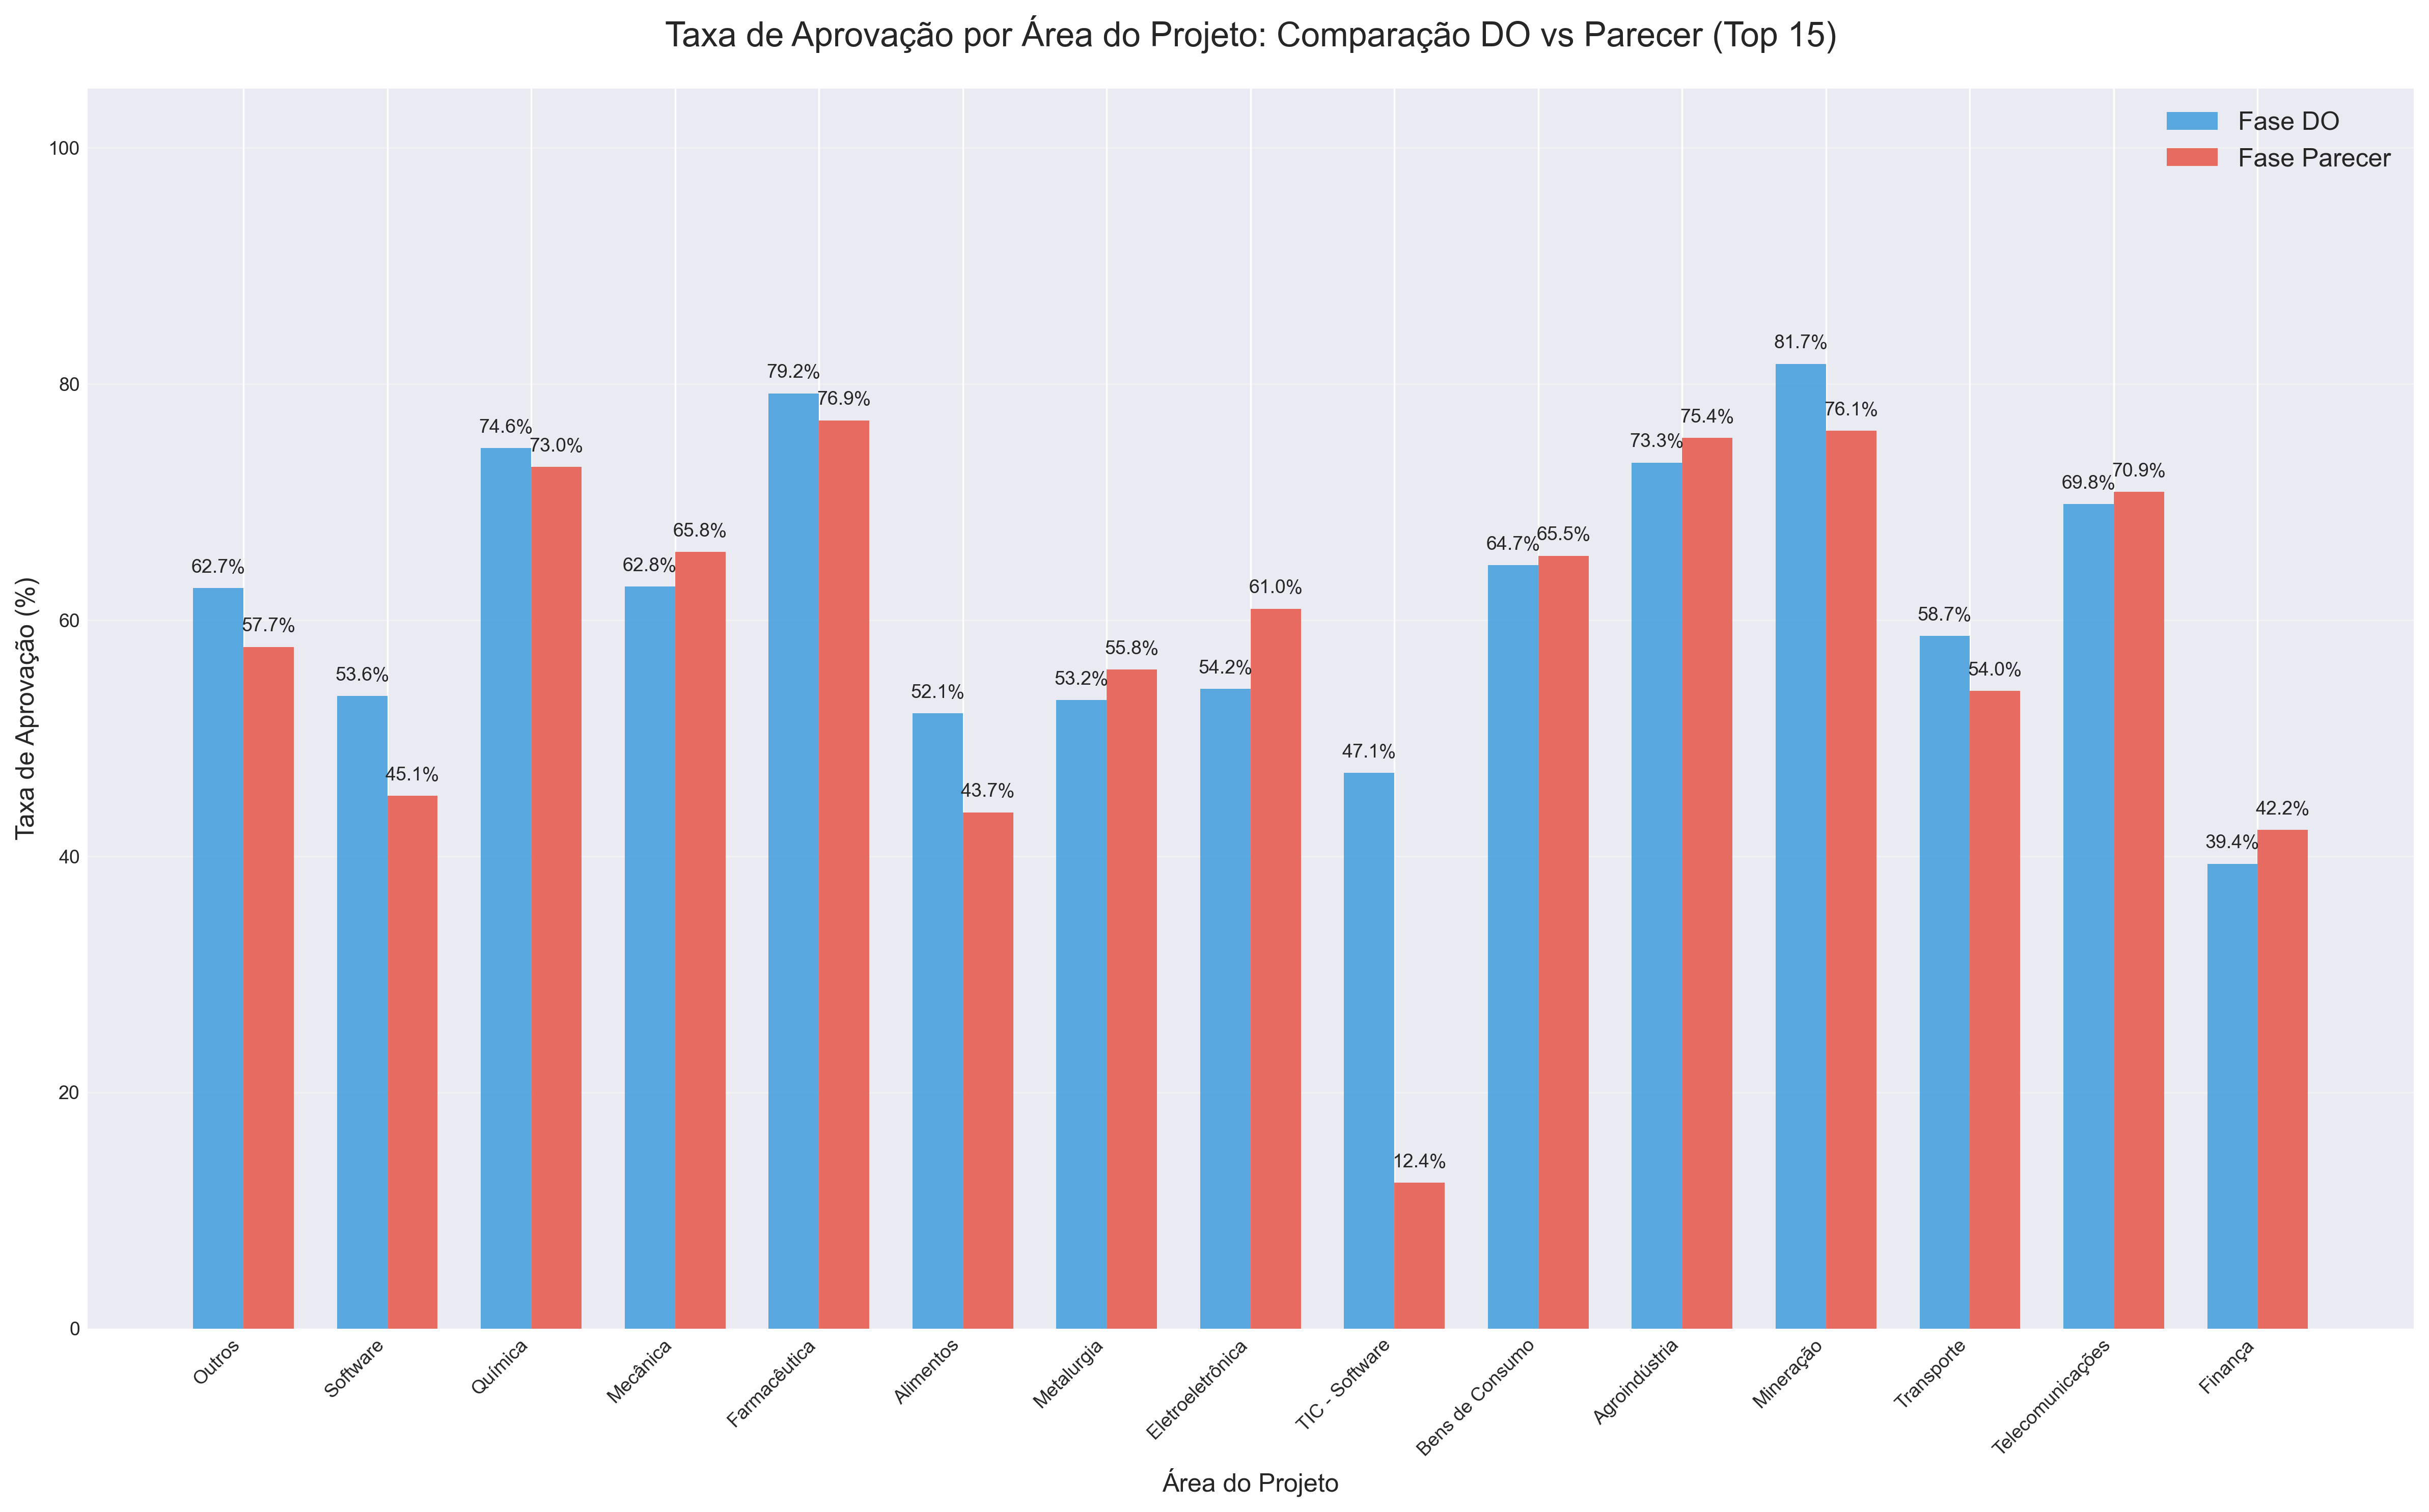

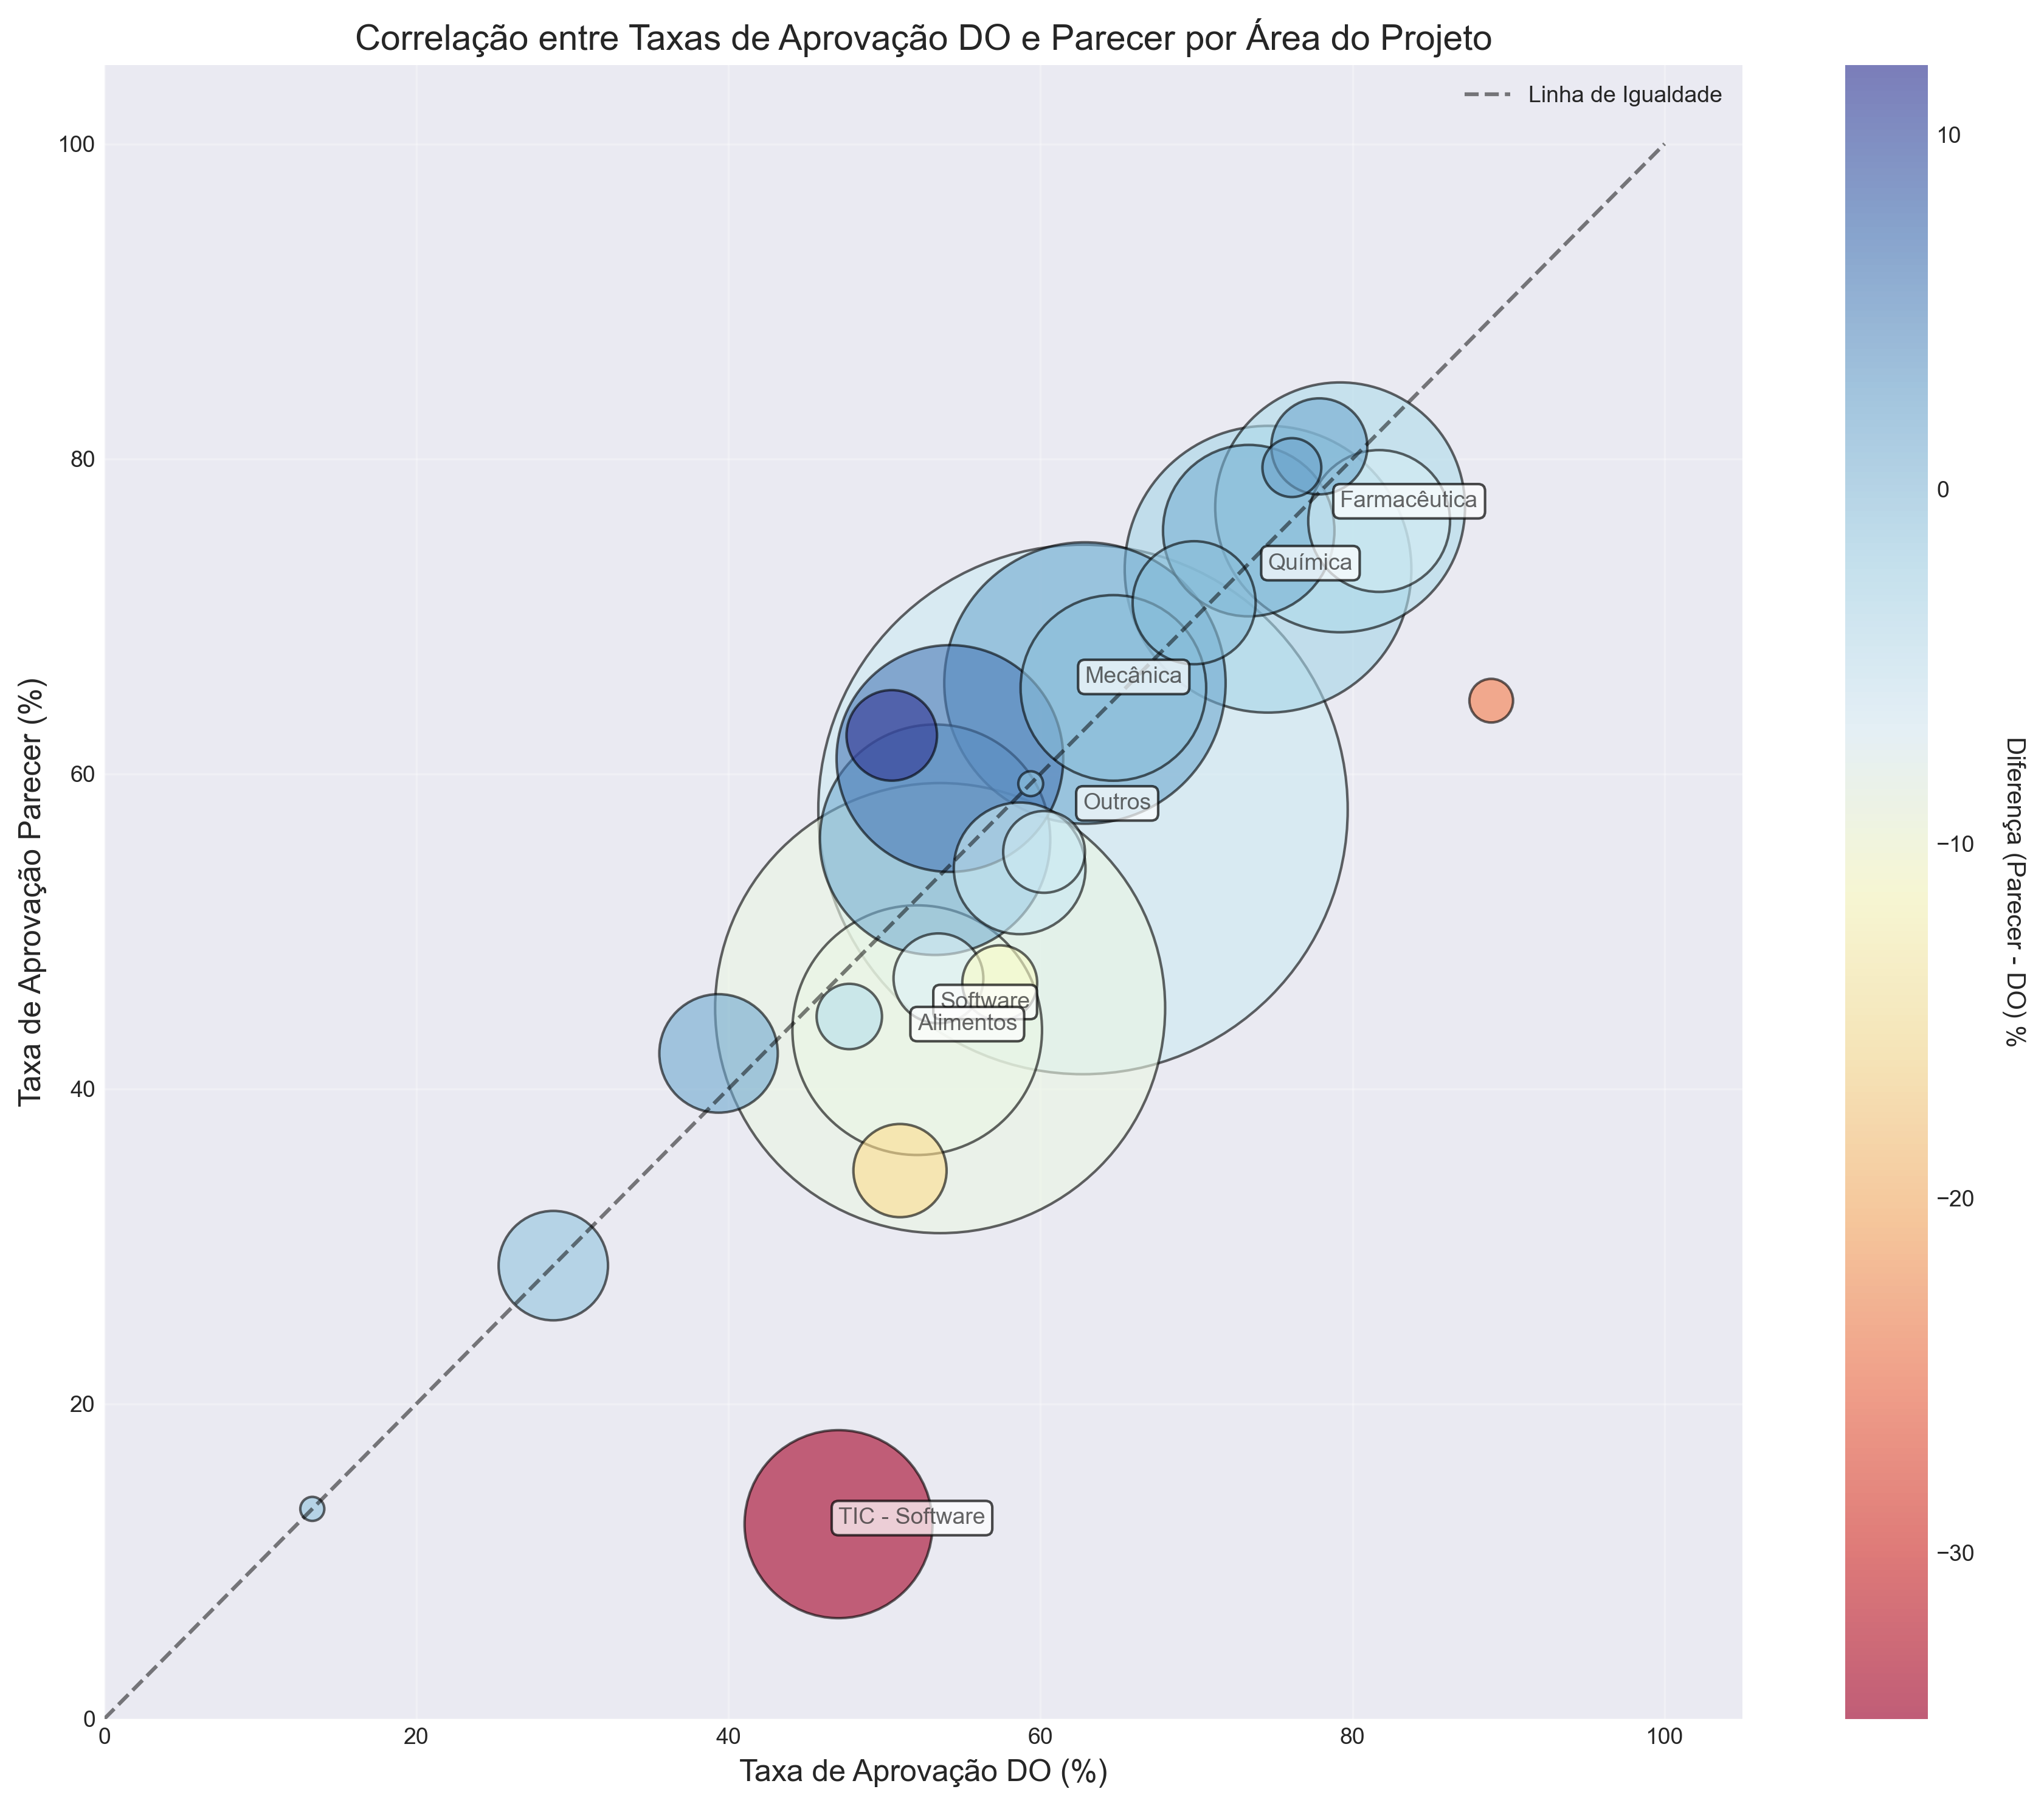

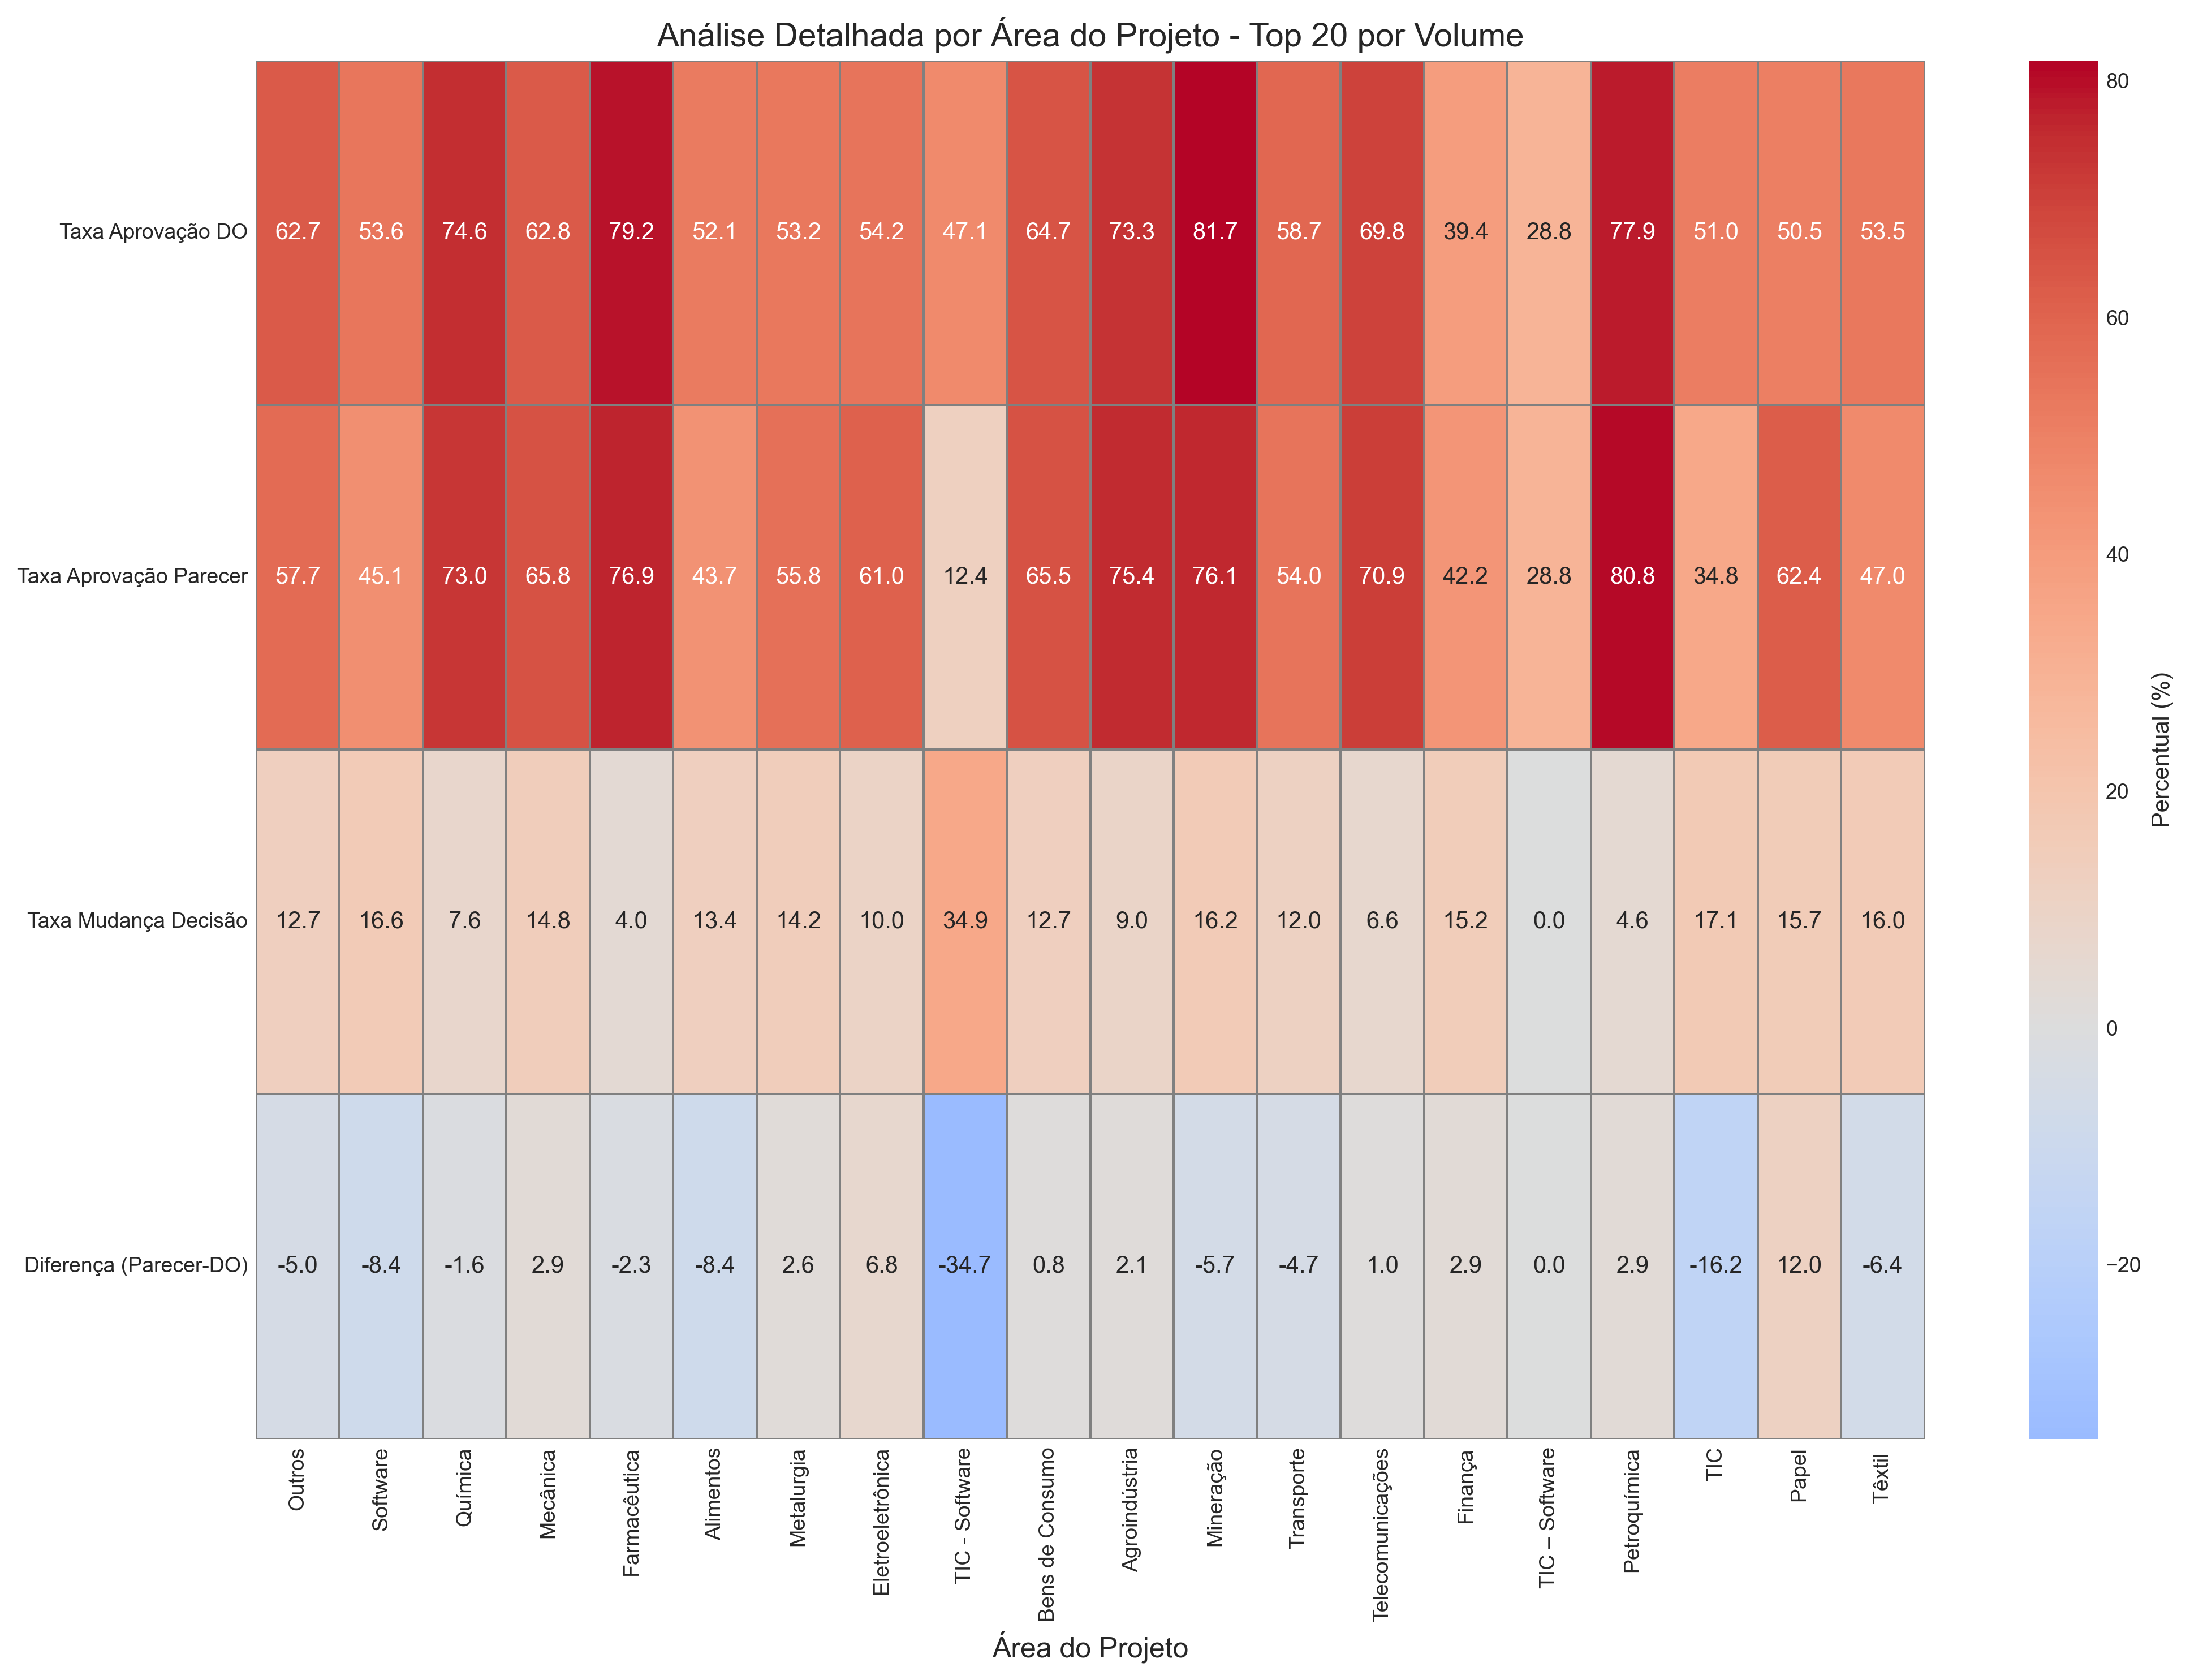

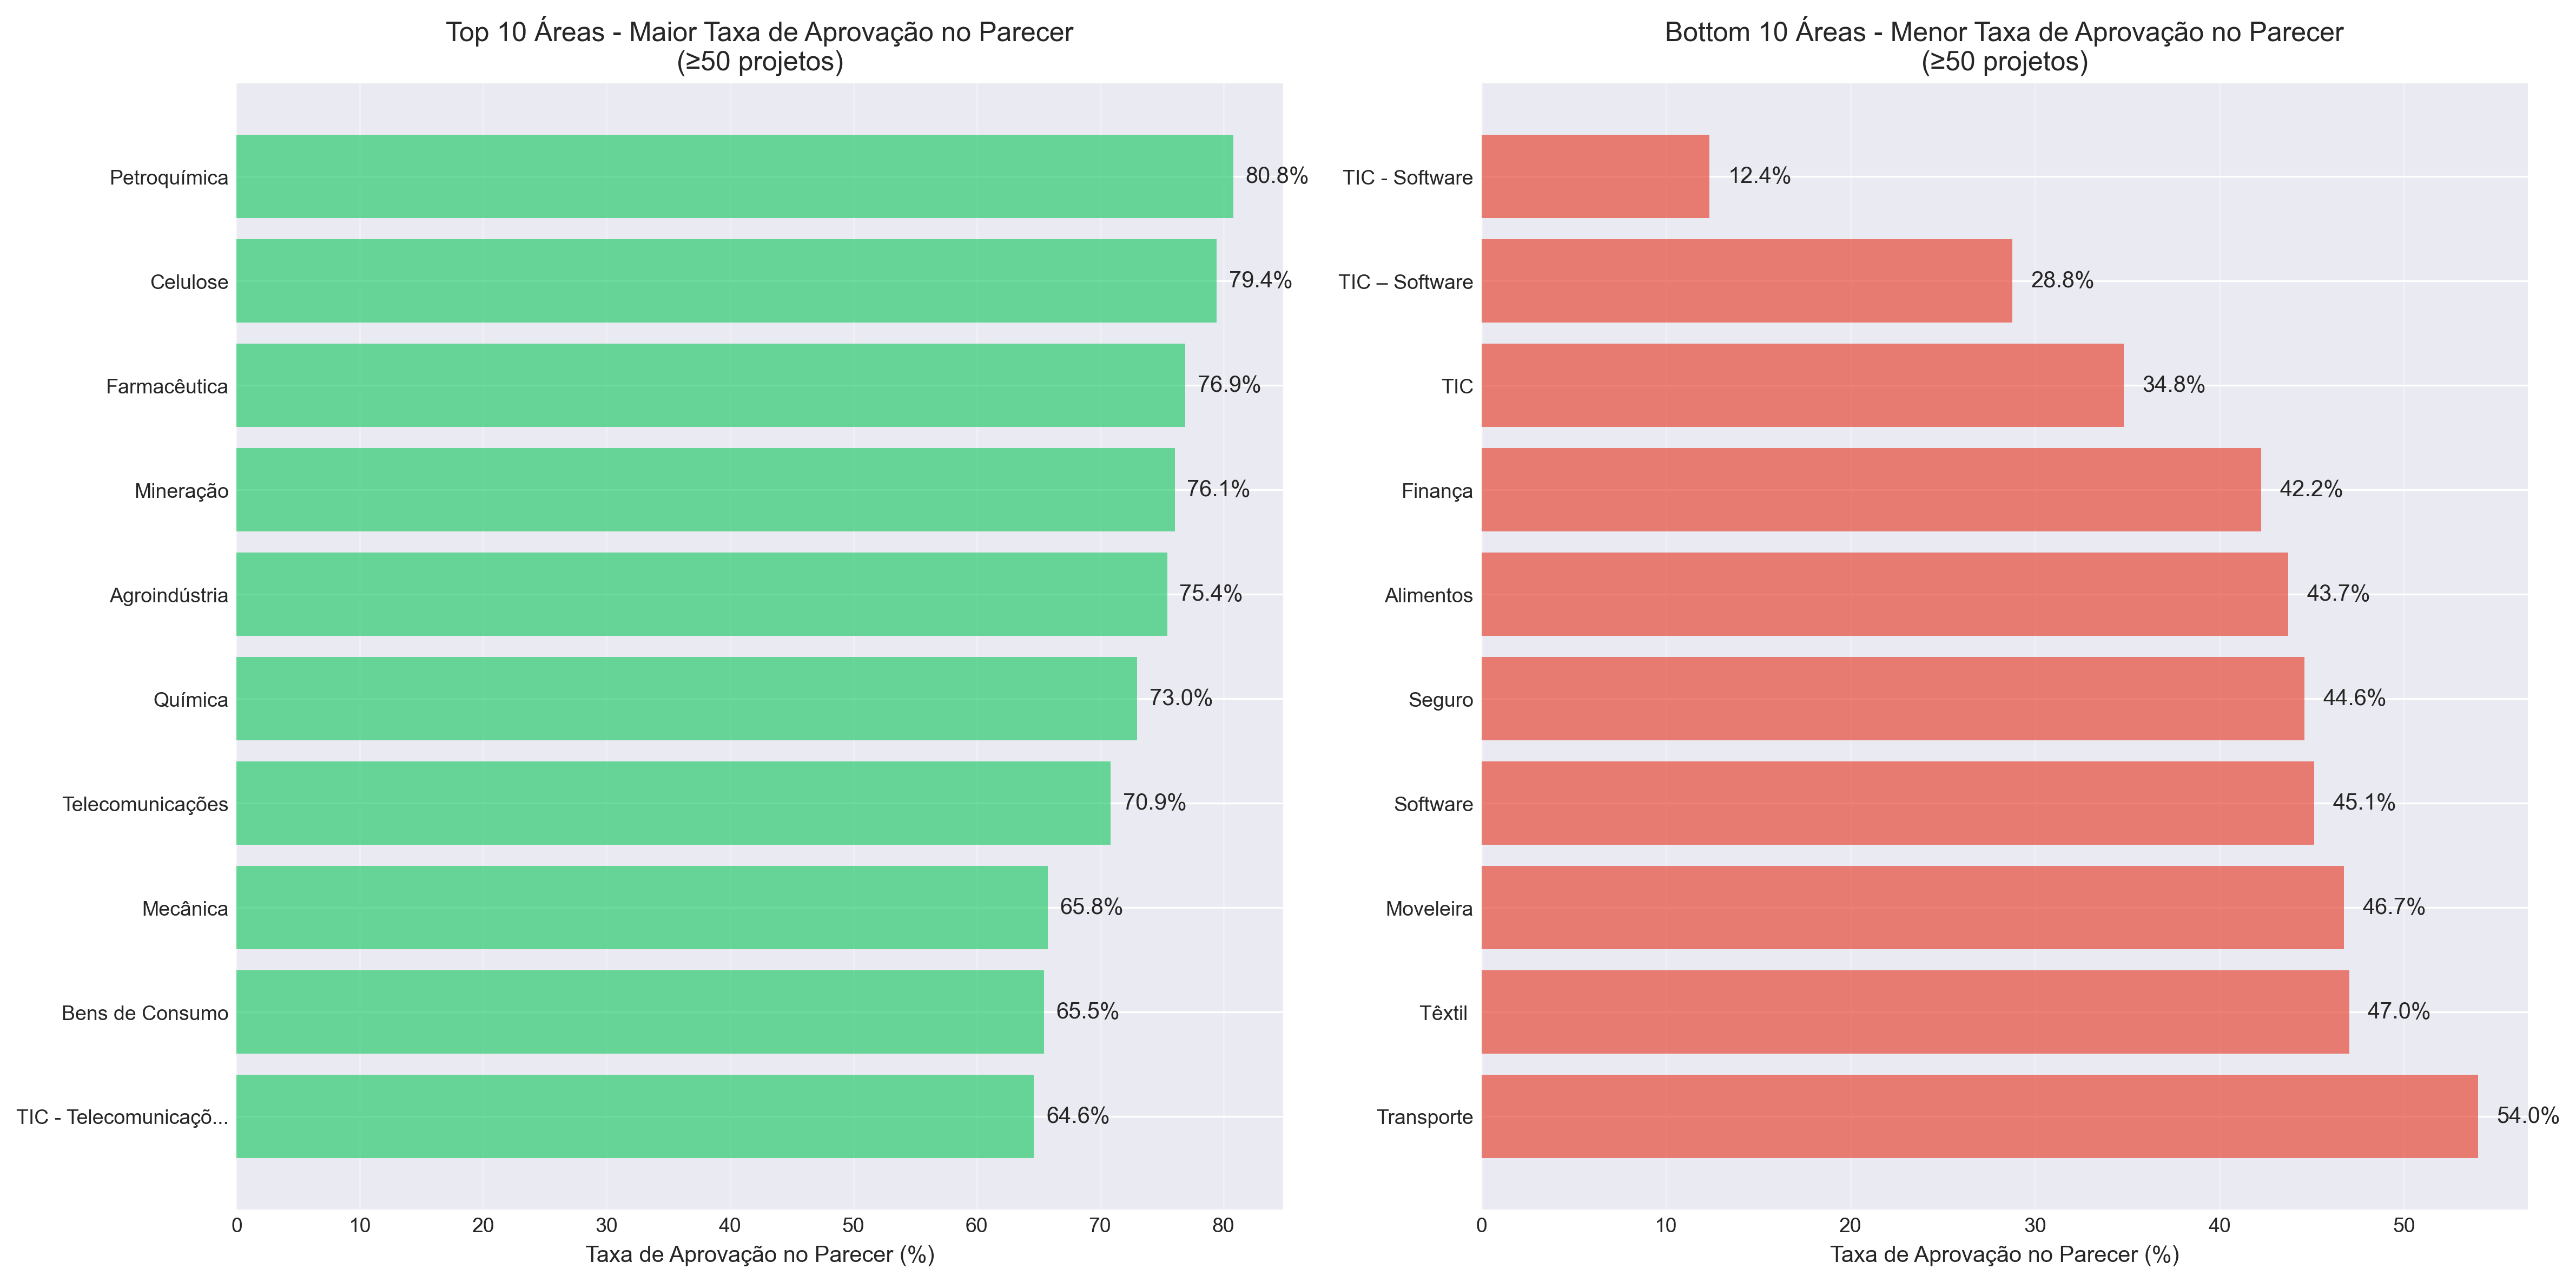


💾 Resultados exportados para 'analise_aprovacao_por_area_projeto.csv'

📊 ESTATÍSTICAS ADICIONAIS:
Áreas com 100% aprovação no Parecer: 0
Áreas com 0% aprovação no Parecer: 0
Área com maior volume: Outros (14557 projetos)
Diferença máxima (Parecer-DO): 12.0%
Diferença mínima (Parecer-DO): -34.7%


In [9]:
# Visualizações para análise por área
if 'df_areas' in locals() and len(df_areas) > 0:
    
    # Visualização 1: Gráfico de barras comparativo DO vs Parecer
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Preparar dados (top 15 áreas por volume)
    top_areas = df_areas.head(15)
    x = np.arange(len(top_areas))
    width = 0.35
    
    # Barras
    bars1 = ax.bar(x - width/2, top_areas['Taxa_Aprovacao_DO_%'], width, 
                   label='Fase DO', color='#3498db', alpha=0.8)
    bars2 = ax.bar(x + width/2, top_areas['Taxa_Aprovacao_Parecer_%'], width,
                   label='Fase Parecer', color='#e74c3c', alpha=0.8)
    
    # Adicionar valores nas barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Configurar eixos
    ax.set_xlabel('Área do Projeto', fontsize=12)
    ax.set_ylabel('Taxa de Aprovação (%)', fontsize=12)
    ax.set_title('Taxa de Aprovação por Área do Projeto: Comparação DO vs Parecer (Top 15)', fontsize=16, pad=20)
    ax.set_xticks(x)
    
    # Labels das áreas (truncar se muito longo)
    labels_areas = [area[:20] + '...' if len(area) > 20 else area for area in top_areas['Area_Projeto']]
    ax.set_xticklabels(labels_areas, rotation=45, ha='right')
    
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim(0, 105)
    
    plt.tight_layout()
    plt.show()
    
    # Visualização 2: Scatter plot - Taxa DO vs Taxa Parecer
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Filtrar áreas com pelo menos 20 projetos para melhor visualização
    df_scatter = df_areas[df_areas['Total_Projetos'] >= 20]
    
    if len(df_scatter) > 0:
        scatter = ax.scatter(df_scatter['Taxa_Aprovacao_DO_%'], 
                           df_scatter['Taxa_Aprovacao_Parecer_%'],
                           s=df_scatter['Total_Projetos']*3,  # Tamanho proporcional
                           c=df_scatter['Diferenca_Taxa_%'],
                           cmap='RdYlBu', alpha=0.6, edgecolors='black', linewidth=1)
        
        # Linha de referência (y = x)
        ax.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Linha de Igualdade')
        
        # Adicionar labels para áreas extremas
        for _, row in df_scatter.iterrows():
            if abs(row['Diferenca_Taxa_%']) > 25 or row['Total_Projetos'] > df_scatter['Total_Projetos'].quantile(0.8):
                label_area = row['Area_Projeto'][:15] + '...' if len(row['Area_Projeto']) > 15 else row['Area_Projeto']
                ax.annotate(label_area, 
                          (row['Taxa_Aprovacao_DO_%'], row['Taxa_Aprovacao_Parecer_%']),
                          fontsize=9, alpha=0.7, 
                          bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        
        ax.set_xlabel('Taxa de Aprovação DO (%)', fontsize=12)
        ax.set_ylabel('Taxa de Aprovação Parecer (%)', fontsize=12)
        ax.set_title('Correlação entre Taxas de Aprovação DO e Parecer por Área do Projeto', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 105)
        ax.set_ylim(0, 105)
        ax.legend()
        
        # Colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Diferença (Parecer - DO) %', rotation=270, labelpad=20)
        
        plt.tight_layout()
        plt.show()
    
    # Visualização 3: Heatmap de análise por área
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Preparar dados para heatmap (top 20 áreas)
    heatmap_data = df_areas.head(20)[['Taxa_Aprovacao_DO_%', 'Taxa_Aprovacao_Parecer_%', 
                                      'Taxa_Mudanca_%', 'Diferenca_Taxa_%']]
    
    # Truncar nomes das áreas para o heatmap
    areas_truncadas = [area[:25] + '...' if len(area) > 25 else area for area in df_areas.head(20)['Area_Projeto']]
    heatmap_data.index = areas_truncadas
    
    sns.heatmap(heatmap_data.T, annot=True, fmt='.1f', cmap='coolwarm', center=0,
               cbar_kws={'label': 'Percentual (%)'}, linewidths=0.5, linecolor='gray')
    
    ax.set_xlabel('Área do Projeto', fontsize=12)
    ax.set_yticklabels(['Taxa Aprovação DO', 'Taxa Aprovação Parecer', 
                      'Taxa Mudança Decisão', 'Diferença (Parecer-DO)'], rotation=0)
    ax.set_title('Análise Detalhada por Área do Projeto - Top 20 por Volume', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Visualização 4: Top e Bottom performers
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Filtrar áreas com pelo menos 50 projetos para análise mais robusta
    df_robustas = df_areas[df_areas['Total_Projetos'] >= 50]
    
    if len(df_robustas) >= 10:
        # Top performers (maior taxa no Parecer)
        top_performers = df_robustas.nlargest(10, 'Taxa_Aprovacao_Parecer_%')
        
        y_pos = np.arange(len(top_performers))
        bars1 = ax1.barh(y_pos, top_performers['Taxa_Aprovacao_Parecer_%'], 
                         color='#2ecc71', alpha=0.7)
        
        ax1.set_yticks(y_pos)
        areas_top = [area[:20] + '...' if len(area) > 20 else area for area in top_performers['Area_Projeto']]
        ax1.set_yticklabels(areas_top)
        ax1.invert_yaxis()
        ax1.set_xlabel('Taxa de Aprovação no Parecer (%)')
        ax1.set_title('Top 10 Áreas - Maior Taxa de Aprovação no Parecer\n(≥50 projetos)', fontsize=12)
        ax1.grid(axis='x', alpha=0.3)
        
        # Adicionar valores nas barras
        for i, (bar, valor) in enumerate(zip(bars1, top_performers['Taxa_Aprovacao_Parecer_%'])):
            ax1.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                    f'{valor:.1f}%', va='center', fontsize=10)
        
        # Bottom performers (menor taxa no Parecer)
        bottom_performers = df_robustas.nsmallest(10, 'Taxa_Aprovacao_Parecer_%')
        
        y_pos2 = np.arange(len(bottom_performers))
        bars2 = ax2.barh(y_pos2, bottom_performers['Taxa_Aprovacao_Parecer_%'], 
                         color='#e74c3c', alpha=0.7)
        
        ax2.set_yticks(y_pos2)
        areas_bottom = [area[:20] + '...' if len(area) > 20 else area for area in bottom_performers['Area_Projeto']]
        ax2.set_yticklabels(areas_bottom)
        ax2.invert_yaxis()
        ax2.set_xlabel('Taxa de Aprovação no Parecer (%)')
        ax2.set_title('Bottom 10 Áreas - Menor Taxa de Aprovação no Parecer\n(≥50 projetos)', fontsize=12)
        ax2.grid(axis='x', alpha=0.3)
        
        # Adicionar valores nas barras
        for i, (bar, valor) in enumerate(zip(bars2, bottom_performers['Taxa_Aprovacao_Parecer_%'])):
            ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                    f'{valor:.1f}%', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Exportar resultados
    df_areas.to_csv('analise_aprovacao_por_area_projeto.csv', index=False, sep=';', encoding='utf-8')
    print("\n💾 Resultados exportados para 'analise_aprovacao_por_area_projeto.csv'")
    
    # Estatísticas adicionais
    print(f"\n📊 ESTATÍSTICAS ADICIONAIS:")
    print(f"Áreas com 100% aprovação no Parecer: {len(df_areas[df_areas['Taxa_Aprovacao_Parecer_%'] == 100])}")
    print(f"Áreas com 0% aprovação no Parecer: {len(df_areas[df_areas['Taxa_Aprovacao_Parecer_%'] == 0])}")
    print(f"Área com maior volume: {df_areas.iloc[0]['Area_Projeto']} ({df_areas.iloc[0]['Total_Projetos']} projetos)")
    print(f"Diferença máxima (Parecer-DO): {df_areas['Diferenca_Taxa_%'].max():.1f}%")
    print(f"Diferença mínima (Parecer-DO): {df_areas['Diferenca_Taxa_%'].min():.1f}%")

else:
    print("\n❌ Não foi possível realizar a análise por área do projeto")
    print("Verifique se a coluna 'daproj_dsareaprojeto' existe e contém dados válidos")

### Análise e Insights por Setor

**O que foi investigado:**

Esta análise focou em identificar padrões de aprovação por setor nas duas fases principais do processo (DO e Parecer), quantificando as diferenças entre as decisões dos analistas técnicos e dos pareceristas para cada setor de atividade.

**Principais Descobertas:**

A análise setorial revela significativas disparidades nas taxas de aprovação entre diferentes setores e entre as fases do processo:

- **Variação Setorial**: As taxas de aprovação variam drasticamente entre setores, tanto na fase DO quanto no Parecer
- **Tendência Geral**: A maioria dos setores apresenta queda na taxa de aprovação entre DO e Parecer, confirmando que os pareceristas aplicam critérios mais rigorosos
- **Setores Favorecidos**: Alguns setores mantêm altas taxas de aprovação em ambas as fases
- **Setores Penalizados**: Certos setores sofrem quedas dramáticas entre as fases

**Padrões Identificados:**

1. **Setores de Alta Performance**: Setores com taxas superiores a 80% em ambas as fases
2. **Setores de Queda Acentuada**: Setores que perdem mais de 20 pontos percentuais entre DO e Parecer
3. **Setores de Reversão**: Raros casos onde a taxa no Parecer supera a do DO
4. **Setores Voláteis**: Alta taxa de mudança de decisão entre fases

**Insights e Implicações Práticas:**

1. **Especialização Setorial**: A variação nas taxas sugere que diferentes setores requerem expertise específica para avaliação adequada

2. **Necessidade de Padronização**: As grandes diferenças entre setores podem indicar falta de critérios uniformes ou vieses setoriais

3. **Oportunidade de Capacitação**: Setores com altas taxas de mudança entre fases podem se beneficiar de treinamento específico para analistas

4. **Revisão de Critérios**: Setores com quedas sistemáticas merecem revisão dos critérios de avaliação aplicados

**Recomendações Específicas:**

- **Criar grupos de trabalho setoriais** para padronizar critérios de avaliação
- **Desenvolver checklists específicos** para cada setor baseados em suas particularidades
- **Implementar revisão cruzada** entre analistas de diferentes setores
- **Monitorar indicadores setoriais** continuamente para identificar tendências
- **Capacitar analistas** nas especificidades técnicas de cada setor